In [ ]:
import math
import mido
from mido import MidiTrack
from mido import MidiFile, MetaMessage, Message

import keras
from keras import backend as K
from keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import pydot
import pydotplus
import tensorflow as tf
import numpy as np
import imageio
import os
from sklearn.utils import shuffle
from IPython.core.display import Image

from pianorollEn_Decoder import pr2midi

In [ ]:
batch_size = 5
num_channels = 1
image_size = [128, 512]
latent_dim = 128

In [ ]:
from os import listdir
from os.path import isfile, join

# Load data
def loadData(filedir, limit=0):
    files = [f for f in listdir(filedir)]
    retMtx = np.array([]).reshape(0,image_size[0],image_size[1])
    curMtx = np.array([]).reshape(0,image_size[0])
    j = 0
    i = 0
    for file in files:
        if j >= limit and limit != 0:
            break
        j += 1
        if file.endswith(".txt"):
            with open(filedir +'/' + file) as f:
                for line in f:
                    line = np.array(line.split(',')).astype(float)
                    if i < image_size[1]:
                        curMtx = np.vstack([curMtx, line])
                        i += 1
                    else:
                        if curMtx.T.shape[1] == image_size[1]:
                            retMtx = np.concatenate([retMtx, curMtx.T.reshape(1,image_size[0],-1)],axis=0)
                        curMtx = np.array([]).reshape(0,image_size[0])
                        i = 0
    if i != 0:
        retMtx = retMtx[:-1,:,:]
    return retMtx

mtx = loadData('Bach_snap', 0)
print(mtx.shape)
data_piano = np.reshape(mtx, (-1, image_size[0], image_size[1], 1))

(59, 128, 512)


In [ ]:
data_piano = data_piano[:55]
print(data_piano.shape)

(55, 128, 512, 1)


In [ ]:
latent_input = keras.Input(shape=(latent_dim,), name="latent")
prev_output = keras.Input(shape=(image_size[0], image_size[1], 1,), name="prev_output")

prev_h0_l = layers.Conv2D(16, (11, 3), strides=(2, 2), input_shape=(image_size[0], image_size[1], 1), padding='same')
prev_h0 = prev_h0_l(prev_output)
prev_h0_l = layers.LeakyReLU(0.1)
prev_h0 = prev_h0_l(prev_h0)

prev_h3_l = layers.Conv2D(16, (3, 11), strides=(2, 2), padding='same')
prev_h3 = prev_h3_l(prev_h0)
prev_h3_l = layers.LeakyReLU(0.1)
prev_h3 = prev_h3_l(prev_h3)

z0 = latent_input
z0 = layers.Dense(image_size[0]/2/2 * image_size[1]/2/2 * 1, activation='relu')(z0)
z1_l = layers.Reshape([int(image_size[0]/2/2), int(image_size[1]/2/2), 1])
z1 = z1_l(z0)

z1 = layers.Concatenate()([prev_h3, z1])
z2 = layers.Conv2DTranspose(16, (3, 11), strides=(2, 2), padding='same')(z1)
z2 = layers.LeakyReLU(0.1)(z2)
z5 = layers.Conv2DTranspose(16, (11, 3), strides=(2, 2), padding='same')(z2)
z5 = layers.Conv2DTranspose(1, (11, 3), strides=(1, 1), padding='same', activation='sigmoid')(z5)

generator = keras.Model(
    inputs=[latent_input, prev_output], 
    outputs=[z5], name="generator"
)

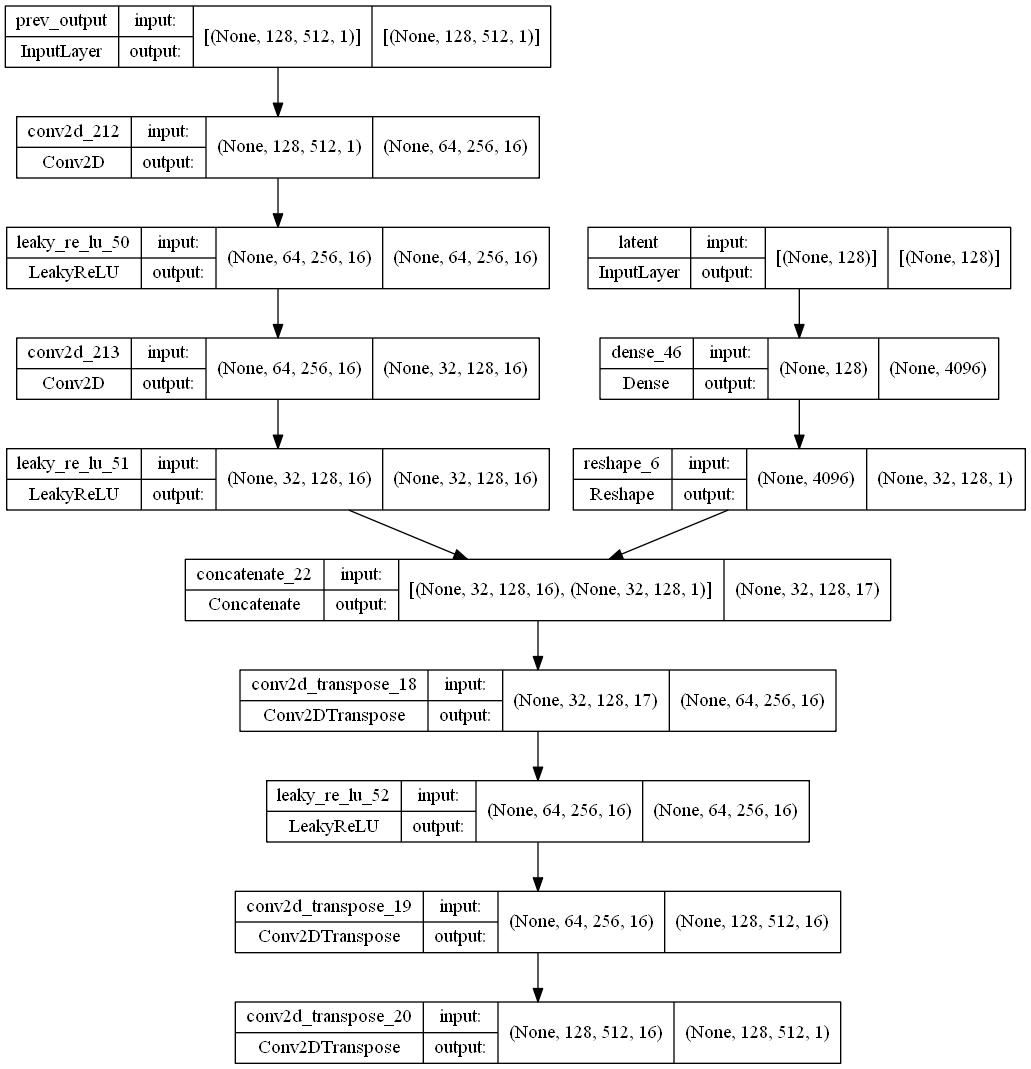

In [ ]:
plot_model(generator, "generator.png", show_shapes=True)

In [ ]:
def major1(shape, dtype):
    f = np.array([[0],[-1],[-1],[1],[-1],[-1],[1],[-1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def major2(shape, dtype):
    f = np.array([[0],[-1],[1],[-1],[-1],[-1],[-1],[1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def major3(shape, dtype):
    f = np.array([[0],[1],[-1],[-1],[-1],[1],[-1],[-1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def minor1(shape, dtype):
    f = np.array([[0],[-1],[-1],[1],[-1],[-1],[-1],[1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def minor2(shape, dtype):
    f = np.array([[0],[-1],[1],[-1],[-1],[-1],[1],[-1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def minor3(shape, dtype):
    f = np.array([[0],[-1],[1],[-1],[-1],[1],[-1],[-1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def dim1(shape, dtype):
    f = np.array([[0],[-1],[-1],[-1],[1],[-1],[-1],[1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def dim2(shape, dtype):
    f = np.array([[0],[1],[-1],[-1],[-1],[-1],[-1],[1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def dim3(shape, dtype):
    f = np.array([[0],[1],[-1],[-1],[1],[-1],[-1],[-1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def dim7(shape, dtype):
    f = np.array([[0],[1],[-1],[-1],[1],[-1],[-1],[1],[-1],[-1],[1]]).reshape([-1,1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def sum24(shape, dtype):
    f = np.ones([image_size[0], image_size[1]//4]).reshape([image_size[0],image_size[1]//4,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

def sumV(shape, dtype):
    f = np.ones([image_size[0], 1]).reshape([image_size[0],1,1,1])
    if shape[2] == 2:
        f = np.concatenate([f, f], axis=2)
        f = np.concatenate([f, f], axis=3)
    return K.variable(f, dtype='float32')

In [ ]:
curr_image = keras.Input(shape=(image_size[0], image_size[1], 1,), name="current image")
prev_image = keras.Input(shape=(image_size[0], image_size[1], 1,), name="previous image")
combined_input = layers.Concatenate(axis=3)([curr_image, prev_image])
z = layers.Conv2D(32, (13, 5), strides=(2, 2), padding='same')(combined_input)
z = layers.LeakyReLU(0.3)(z)
z = layers.Dropout(0.3)(z)
z = layers.Conv2D(32, (13, 5), strides=(2, 2), padding='same')(z)
z = layers.LeakyReLU(0.3)(z)
z = layers.Dropout(0.3)(z)
z = layers.Conv2D(32, (5, 13), strides=(2, 2), padding='same')(z)
z = layers.LeakyReLU(0.3)(z)
z = layers.Dropout(0.3)(z)
z = layers.Conv2D(8, (5, 13), strides=(2, 2), padding='same')(z)
z = layers.LeakyReLU(0.3)(z)
z = layers.Dropout(0.3)(z)
z = layers.Flatten()(z)
z = layers.Dense(1024, activation='relu')(z)
z = layers.Dropout(0.4)(z)
z = layers.Dense(64, activation='relu')(z)

chordMj1 = layers.Conv2D(1, (11, 1), kernel_initializer=major1, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMj1 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMj1)
chordMj1 = layers.Flatten()(chordMj1)
# z = layers.Concatenate()([z, chordMj1])

chordMj2 = layers.Conv2D(1, (11, 1), kernel_initializer=major2, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMj2 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMj2)
chordMj2 = layers.Flatten()(chordMj2)
# z = layers.Concatenate()([z, chordMj2])

chordMj3 = layers.Conv2D(1, (11, 1), kernel_initializer=major3, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMj3 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMj3)
chordMj3 = layers.Flatten()(chordMj3)
# z = layers.Concatenate()([z, chordMj3])

chordMn1 = layers.Conv2D(1, (11, 1), kernel_initializer=minor1, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMn1 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMn1)
chordMn1 = layers.Flatten()(chordMn1)
# z = layers.Concatenate()([z, chordMn1])

chordMn2 = layers.Conv2D(1, (11, 1), kernel_initializer=minor2, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMn2 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMn2)
chordMn2 = layers.Flatten()(chordMn2)
# z = layers.Concatenate()([z, chordMn2])

chordMn3 = layers.Conv2D(1, (11, 1), kernel_initializer=minor3, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordMn3 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordMn3)
chordMn3 = layers.Flatten()(chordMn3)
# z = layers.Concatenate()([z, chordMn3])

chordDm1 = layers.Conv2D(1, (11, 1), kernel_initializer=dim1, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordDm1 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordDm1)
chordDm1 = layers.Flatten()(chordDm1)
# z = layers.Concatenate()([z, chordDm1])

chordDm2 = layers.Conv2D(1, (11, 1), kernel_initializer=dim2, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordDm2 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordDm2)
chordDm2 = layers.Flatten()(chordDm2)
# z = layers.Concatenate()([z, chordDm2])

chordDm3 = layers.Conv2D(1, (11, 1), kernel_initializer=dim3, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordDm3 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordDm3)
chordDm3 = layers.Flatten()(chordDm3)
# z = layers.Concatenate()([z, chordDm3])

chordDm7 = layers.Conv2D(1, (11, 1), kernel_initializer=dim7, strides=(1, 1), padding='same', trainable=False)(curr_image)
chordDm7 = layers.Conv2D(1, (image_size[0], image_size[1]//4), kernel_initializer=sum24, strides=(1, image_size[1]//4), padding='valid', trainable=False)(chordDm7)
chordDm7 = layers.Flatten()(chordDm7)

VertSum = layers.Conv2D(1, (image_size[0], 1), kernel_initializer=sumV, strides=(1, 1), padding='valid')(curr_image)
VertSum = layers.Flatten()(VertSum)
VertSum = layers.Dense(8, activation='relu')(VertSum)
z = layers.Concatenate()([z, chordMj1, chordMj2, chordMj3, chordMn1, chordMn2, chordMn3, chordDm1, chordDm2, chordDm3, chordDm7, VertSum])

z = layers.Dense(16, activation='relu')(z)
z = layers.Dense(1, activation='sigmoid')(z)

discriminator = keras.Model(
    inputs=[curr_image, prev_image], 
    outputs=[z], name="discriminator"
)

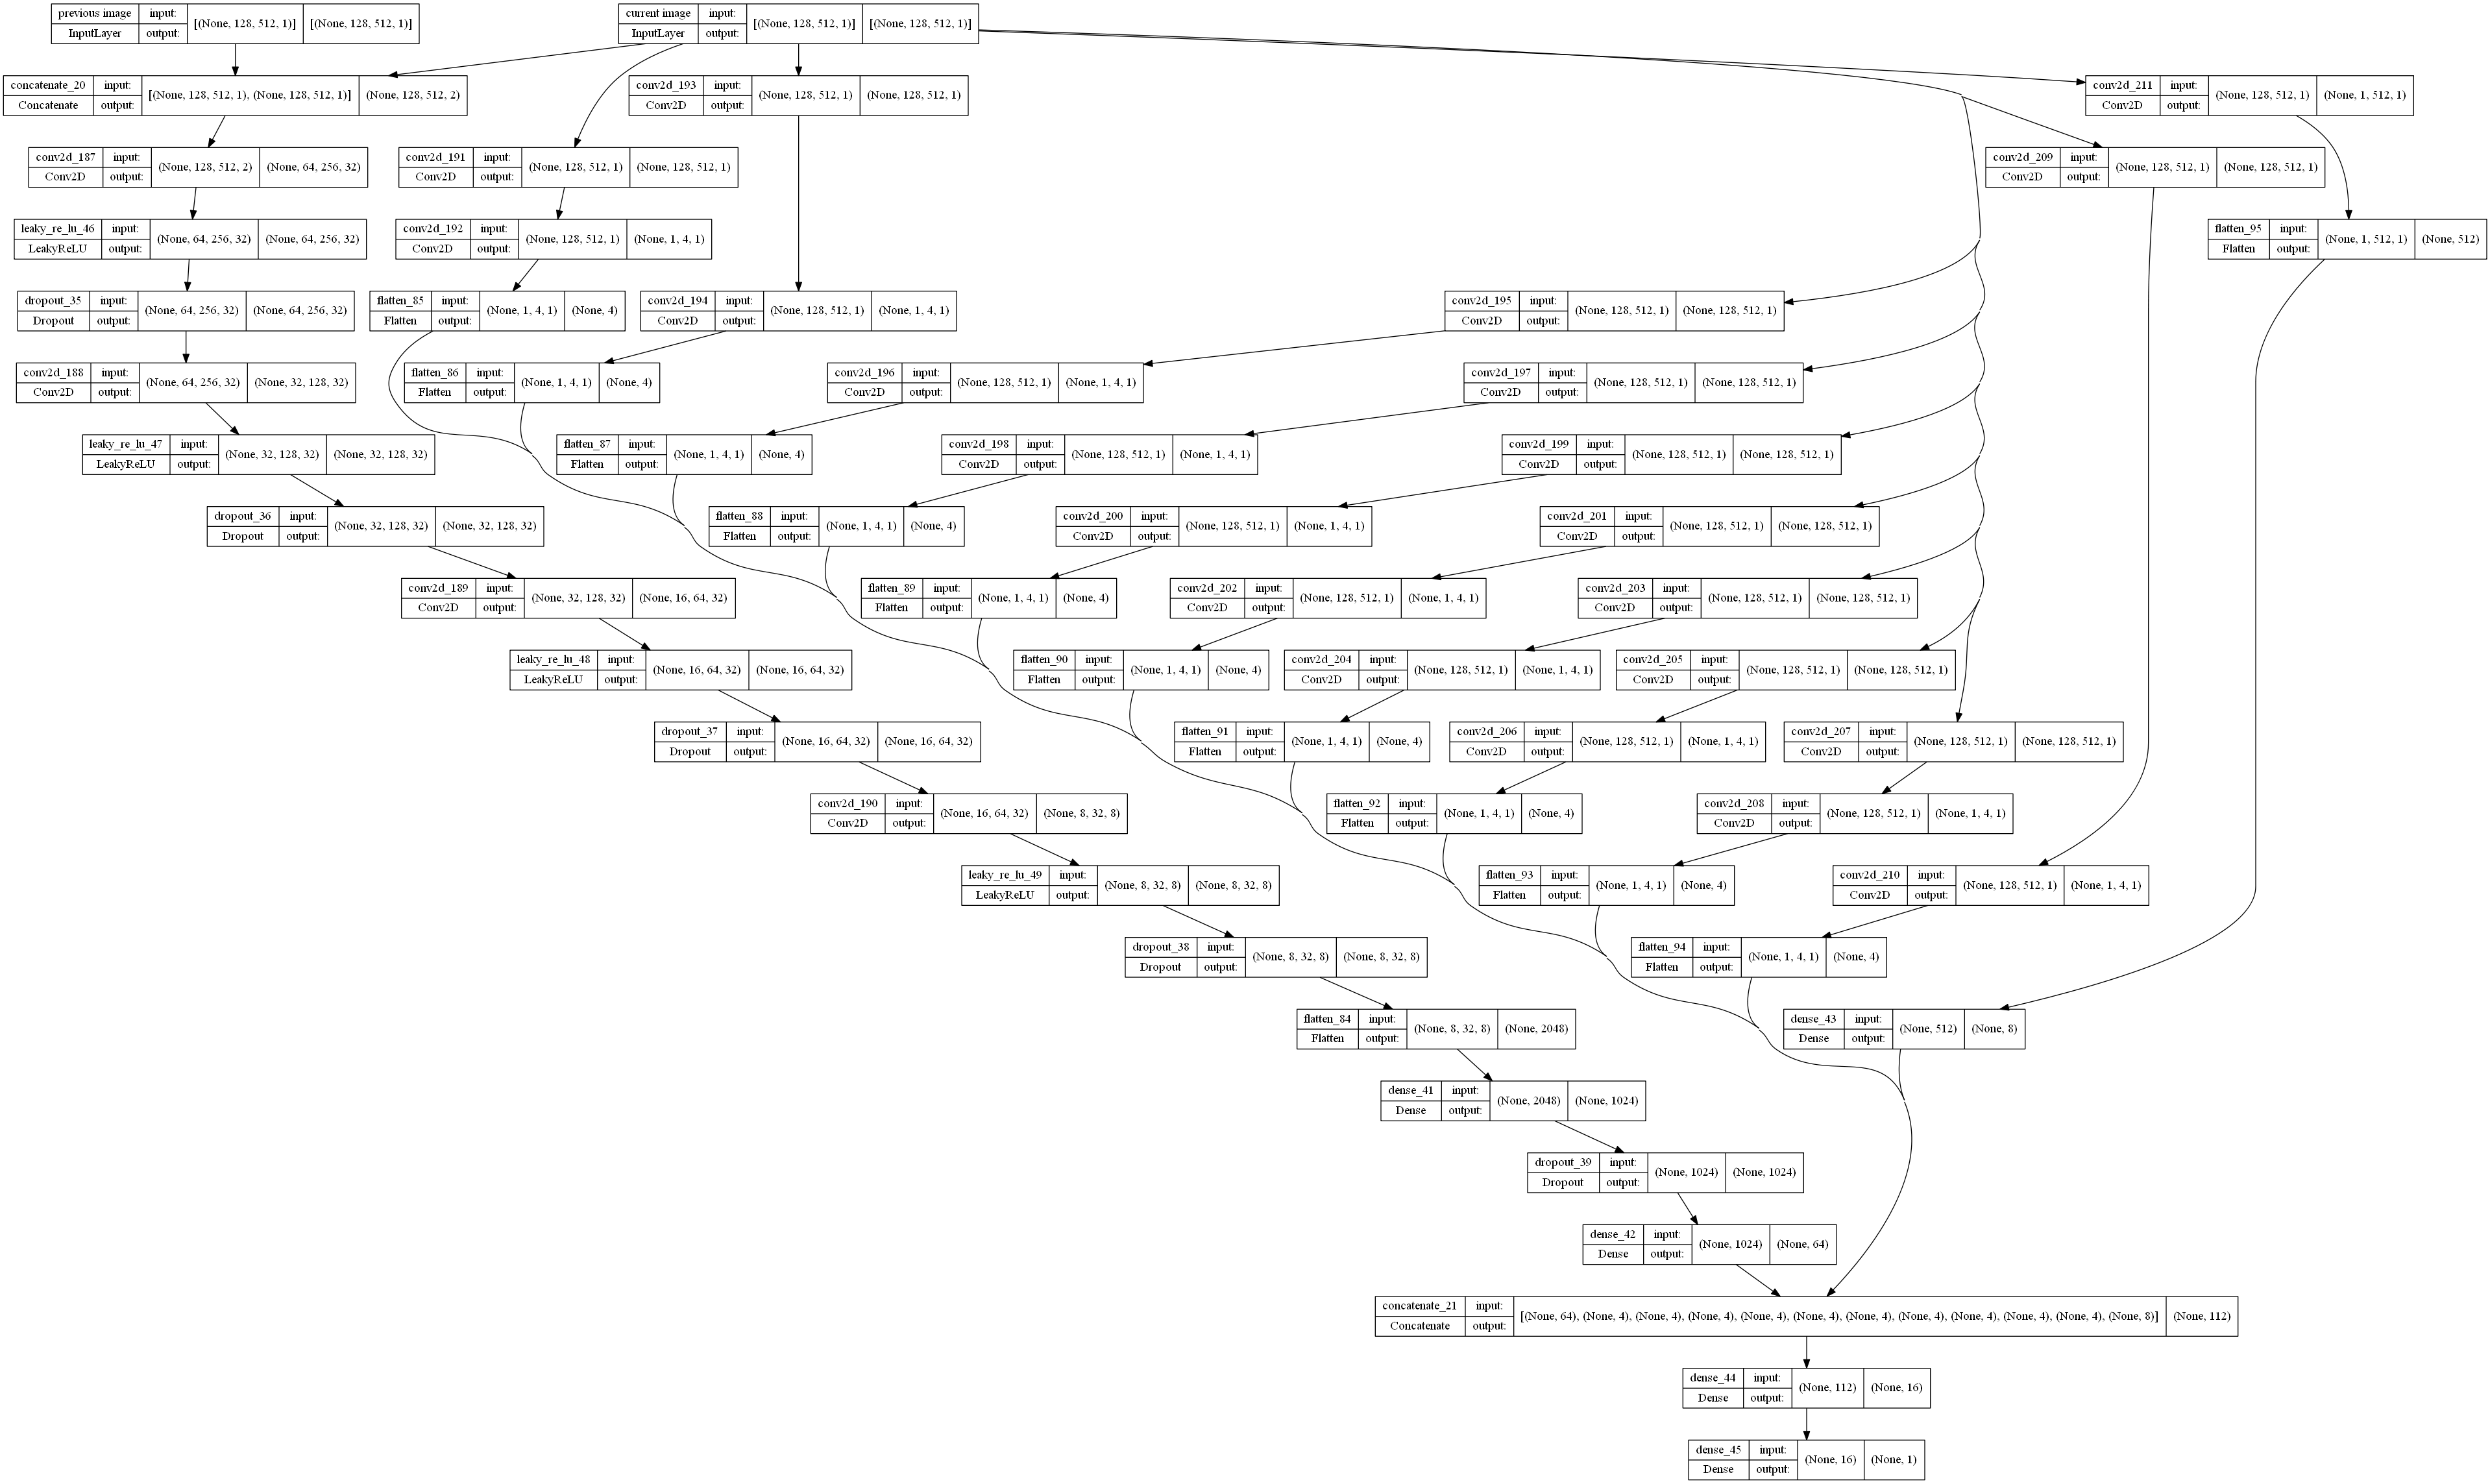

In [ ]:
plot_model(discriminator, "discriminator.png", show_shapes=True)

In [ ]:
class R_CNN_GAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim, image_shape, batch_size):
        super(R_CNN_GAN, self).__init__()
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_acc_tracker = keras.metrics.Mean(name="real_2_real")
        self.fake_acc_tracker = keras.metrics.Mean(name="fake_2_real")
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.batch_size = batch_size
        
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, real_acc, fake_acc, loss_fn):
        super(R_CNN_GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.real_acc = real_acc
        self.fake_acc = fake_acc
        self.loss_fn = loss_fn
        
    def train_step(self, data):
        # Unpack the data.
        real_images = data
        image_shape = self.image_shape

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = real_images.shape[0]
        prev_output = tf.reshape(real_images[0], [1, self.image_shape[0], self.image_shape[1], 1])
        real_prev_images = real_images[:-1]

        # Decode the noise to fake images.
        generated_images = np.empty([0, image_shape[0], image_shape[1], 1])
        for i in range(self.batch_size-1):
            prev_output = self.generator([tf.random.normal(shape=(1, self.latent_dim)), tf.reshape(real_prev_images[i], [1, image_shape[0], image_shape[1], 1])])
            generated_images = tf.concat([generated_images, prev_output], axis=0)
        generated_prev_images = tf.concat([tf.reshape(real_images[0], [1, image_shape[0], image_shape[1], 1]), generated_images[:-1]], axis=0)
        
        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        
        combined_images = tf.concat(
            [generated_images, real_images[1:]], axis=0
        )
        combined_prev_images = tf.concat(
            [generated_prev_images, real_prev_images], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((self.batch_size-1, 1)), tf.zeros((self.batch_size-1, 1))], axis=0
        )
        
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(inputs=[combined_images, combined_prev_images])
            real_predictions = self.discriminator(inputs=[real_images[1:], real_prev_images])
            fake_predictions = self.discriminator(inputs=[generated_images, real_prev_images])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((self.batch_size-1, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        prev_output = tf.reshape(real_images[0], [1, image_shape[0], image_shape[1], 1])
        
        with tf.GradientTape() as tape:
            generated_images = np.empty([0, image_shape[0], image_shape[1], 1])
            for i in range(self.batch_size-1):
                prev_output = self.generator([tf.random.normal(shape=(1, self.latent_dim)), tf.reshape(real_prev_images[i], [1, image_shape[0], image_shape[1], 1])])
                generated_images = tf.concat([generated_images, prev_output], axis=0)
            generated_prev_images = tf.concat([tf.reshape(real_images[0], [1, image_shape[0], image_shape[1], 1]), generated_images[:-1]], axis=0)
            predictions = self.discriminator(inputs=[generated_images, real_prev_images])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.real_acc.update_state(tf.zeros((self.batch_size-1, 1)), real_predictions)
        self.fake_acc.update_state(tf.zeros((self.batch_size-1, 1)), fake_predictions)
        self.real_acc_tracker.update_state(self.real_acc.result())
        self.fake_acc_tracker.update_state(self.fake_acc.result())
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "r as r": self.real_acc_tracker.result(),
            "f as r": self.fake_acc_tracker.result()
        }

In [ ]:
prev_output = data_piano[:-1]
curr_output = data_piano[1:]
curr_noise = np.zeros([60, image_size[0], image_size[1], 1])
prev_noise = np.zeros([60, image_size[0], image_size[1], 1])
combined_images = tf.concat(
    [curr_noise, curr_output], axis=0
)
combined_prev_images = tf.concat(
    [prev_noise, prev_output], axis=0
)
labels = tf.concat(
    [tf.zeros((data_piano.shape[0]-1, 1)), tf.zeros((60, 1))], axis=0
)
        
with tf.GradientTape() as tape:
    predictions = discriminator(inputs=[combined_images, combined_prev_images])
    d_loss = keras.losses.BinaryCrossentropy()(labels, predictions)
grads = tape.gradient(d_loss, discriminator.trainable_weights)
tf.keras.optimizers.Adam(learning_rate=0.0001).apply_gradients(zip(grads, discriminator.trainable_weights))

print(d_loss)

tf.Tensor(42.28303, shape=(), dtype=float32)


In [ ]:
for j in range(10):
    previous = data_piano

    labels = tf.zeros((generated_images.shape[0], 1))

    with tf.GradientTape() as tape:
        generated_images = np.empty([0, image_size[0], image_size[1], 1])
        for i in range(previous.shape[0]-1):
            prev_output = generator([tf.random.normal(shape=(1, latent_dim)), tf.reshape(previous[i], [1, image_size[0], image_size[1], 1])])
            generated_images = tf.concat([generated_images, prev_output], axis=0)
        predictions = discriminator(inputs=[generated_images, previous[:-1]])
        g_loss = keras.losses.BinaryCrossentropy()(labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    tf.keras.optimizers.Adam(learning_rate=0.001).apply_gradients(zip(grads, generator.trainable_weights))

    print(g_loss)

tf.Tensor(0.28190726, shape=(), dtype=float32)
tf.Tensor(0.26494864, shape=(), dtype=float32)
tf.Tensor(0.26077512, shape=(), dtype=float32)
tf.Tensor(0.22485179, shape=(), dtype=float32)
tf.Tensor(0.2588103, shape=(), dtype=float32)
tf.Tensor(0.32431108, shape=(), dtype=float32)
tf.Tensor(0.2373101, shape=(), dtype=float32)
tf.Tensor(0.23087028, shape=(), dtype=float32)
tf.Tensor(0.2237589, shape=(), dtype=float32)
tf.Tensor(0.23993899, shape=(), dtype=float32)


In [ ]:
class Monitor(keras.callbacks.Callback):
    def __init__(self, starting_img, latent_dim=128):
        self.latent_dim = latent_dim
        self.starting_img = starting_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % 10 == 0):
            generated = np.array([]).reshape([image_size[0],0])
            prev_output = self.starting_img
            prev_reshape = np.reshape(prev_output,[1,image_size[0],image_size[1],1])
            for i in range(5):
                prev_reshape = generator([tf.random.normal(shape=(1, self.latent_dim)), prev_reshape])
                generated = np.hstack([generated, np.squeeze(prev_reshape)])
            generated *= 255
            generated = np.reshape(generated,[image_size[0],-1,1])
            generated = np.concatenate([generated, generated, generated], axis=2)
            img = keras.preprocessing.image.array_to_img(generated)
            img.save("rcnngan_training_15/generated_img_%03d.bmp" % (epoch))
            
            self.model.save_weights("rcnngan_training_15/weights.%03d.ckpt" % (epoch))

In [ ]:
rcnn = R_CNN_GAN(generator=generator, discriminator=discriminator, 
                 latent_dim=latent_dim, image_shape=image_size, batch_size=batch_size)
rcnn.compile(
  d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00000001),
  g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  real_acc=tf.keras.metrics.BinaryAccuracy(),
  fake_acc=tf.keras.metrics.BinaryAccuracy(),
  loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
# Train the model with the new callback
rcnn.fit(data_piano, 
         epochs=10000,
         batch_size=batch_size,
         callbacks=[Monitor(data_piano[1,:,:], latent_dim)])  # Pass callback to training

Epoch 1/10000
11/11 [==============================] - 6s 179ms/step - g_loss: 0.3047 - d_loss: 0.4535 - r as r: 0.9061 - f as r: 0.9677
Epoch 2/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2607 - d_loss: 0.4361 - r as r: 0.8558 - f as r: 0.9217
Epoch 3/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3300 - d_loss: 0.4745 - r as r: 0.8423 - f as r: 0.9242
Epoch 4/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2987 - d_loss: 0.5307 - r as r: 0.8366 - f as r: 0.9281
Epoch 5/10000
11/11 [==============================] - 2s 156ms/step - g_loss: 0.3481 - d_loss: 0.4571 - r as r: 0.8296 - f as r: 0.9326
Epoch 6/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.3222 - d_loss: 0.3992 - r as r: 0.8223 - f as r: 0.9355
Epoch 7/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2902 - d_loss: 0.5185 - r as r: 0.8159 - f as r: 0.9374
Epoch 8/10000
11/11 [====================

11/11 [==============================] - 2s 151ms/step - g_loss: 0.2137 - d_loss: 0.5462 - r as r: 0.7356 - f as r: 0.9589
Epoch 59/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2098 - d_loss: 0.6096 - r as r: 0.7353 - f as r: 0.9590
Epoch 60/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1693 - d_loss: 0.4875 - r as r: 0.7350 - f as r: 0.9592
Epoch 61/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1928 - d_loss: 0.5316 - r as r: 0.7347 - f as r: 0.9594
Epoch 62/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1850 - d_loss: 0.5537 - r as r: 0.7345 - f as r: 0.9596
Epoch 63/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2299 - d_loss: 0.4916 - r as r: 0.7342 - f as r: 0.9598
Epoch 64/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1984 - d_loss: 0.6102 - r as r: 0.7340 - f as r: 0.9599
Epoch 65/10000
11/11 [===========================

11/11 [==============================] - 2s 153ms/step - g_loss: 0.1469 - d_loss: 0.7577 - r as r: 0.7244 - f as r: 0.9684
Epoch 118/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1299 - d_loss: 0.7072 - r as r: 0.7242 - f as r: 0.9685
Epoch 119/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1260 - d_loss: 0.8195 - r as r: 0.7241 - f as r: 0.9687
Epoch 120/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1405 - d_loss: 0.6435 - r as r: 0.7239 - f as r: 0.9688
Epoch 121/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1517 - d_loss: 0.7375 - r as r: 0.7237 - f as r: 0.9689
Epoch 122/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1408 - d_loss: 0.6640 - r as r: 0.7235 - f as r: 0.9690
Epoch 123/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1602 - d_loss: 0.7045 - r as r: 0.7234 - f as r: 0.9692
Epoch 124/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.2539 - d_loss: 0.6220 - r as r: 0.7139 - f as r: 0.9742
Epoch 177/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2419 - d_loss: 0.6067 - r as r: 0.7137 - f as r: 0.9742
Epoch 178/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2274 - d_loss: 0.6637 - r as r: 0.7136 - f as r: 0.9743
Epoch 179/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1752 - d_loss: 0.5518 - r as r: 0.7134 - f as r: 0.9743
Epoch 180/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2184 - d_loss: 0.7100 - r as r: 0.7132 - f as r: 0.9744
Epoch 181/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.1891 - d_loss: 0.5520 - r as r: 0.7131 - f as r: 0.9745
Epoch 182/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1800 - d_loss: 0.5607 - r as r: 0.7129 - f as r: 0.9745
Epoch 183/10000
11/11 [====================

11/11 [==============================] - 2s 153ms/step - g_loss: 0.4363 - d_loss: 0.4794 - r as r: 0.7063 - f as r: 0.9759
Epoch 236/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3466 - d_loss: 0.4514 - r as r: 0.7062 - f as r: 0.9758
Epoch 237/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3332 - d_loss: 0.4770 - r as r: 0.7062 - f as r: 0.9757
Epoch 238/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3616 - d_loss: 0.5389 - r as r: 0.7061 - f as r: 0.9757
Epoch 239/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.4550 - d_loss: 0.4747 - r as r: 0.7060 - f as r: 0.9756
Epoch 240/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.3482 - d_loss: 0.4262 - r as r: 0.7060 - f as r: 0.9755
Epoch 241/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.3201 - d_loss: 0.4749 - r as r: 0.7059 - f as r: 0.9754
Epoch 242/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1802 - d_loss: 0.5655 - r as r: 0.7046 - f as r: 0.9719
Epoch 295/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1839 - d_loss: 0.5367 - r as r: 0.7046 - f as r: 0.9718
Epoch 296/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2096 - d_loss: 0.5257 - r as r: 0.7046 - f as r: 0.9718
Epoch 297/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.2244 - d_loss: 0.6326 - r as r: 0.7046 - f as r: 0.9717
Epoch 298/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.4505 - d_loss: 0.4058 - r as r: 0.7046 - f as r: 0.9717
Epoch 299/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2485 - d_loss: 0.4553 - r as r: 0.7046 - f as r: 0.9716
Epoch 300/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2579 - d_loss: 0.5232 - r as r: 0.7046 - f as r: 0.9716
Epoch 301/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1582 - d_loss: 0.6760 - r as r: 0.7050 - f as r: 0.9696
Epoch 354/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1289 - d_loss: 0.6313 - r as r: 0.7050 - f as r: 0.9696
Epoch 355/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1394 - d_loss: 0.6304 - r as r: 0.7050 - f as r: 0.9696
Epoch 356/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1425 - d_loss: 0.6435 - r as r: 0.7050 - f as r: 0.9696
Epoch 357/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1237 - d_loss: 0.5822 - r as r: 0.7050 - f as r: 0.9695
Epoch 358/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1500 - d_loss: 0.6127 - r as r: 0.7050 - f as r: 0.9695
Epoch 359/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1490 - d_loss: 0.6029 - r as r: 0.7051 - f as r: 0.9695
Epoch 360/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1054 - d_loss: 0.7432 - r as r: 0.7055 - f as r: 0.9686
Epoch 413/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1177 - d_loss: 0.6788 - r as r: 0.7055 - f as r: 0.9686
Epoch 414/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0921 - d_loss: 0.6794 - r as r: 0.7055 - f as r: 0.9686
Epoch 415/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1099 - d_loss: 0.6493 - r as r: 0.7056 - f as r: 0.9686
Epoch 416/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1190 - d_loss: 0.7067 - r as r: 0.7056 - f as r: 0.9686
Epoch 417/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1220 - d_loss: 0.8126 - r as r: 0.7056 - f as r: 0.9686
Epoch 418/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1016 - d_loss: 0.6988 - r as r: 0.7056 - f as r: 0.9686
Epoch 419/10000
11/11 [====================

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0844 - d_loss: 0.7147 - r as r: 0.7054 - f as r: 0.9685
Epoch 472/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0945 - d_loss: 0.7768 - r as r: 0.7054 - f as r: 0.9685
Epoch 473/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1003 - d_loss: 0.7086 - r as r: 0.7054 - f as r: 0.9685
Epoch 474/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0910 - d_loss: 0.7359 - r as r: 0.7054 - f as r: 0.9685
Epoch 475/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0717 - d_loss: 0.6799 - r as r: 0.7054 - f as r: 0.9685
Epoch 476/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0743 - d_loss: 0.8085 - r as r: 0.7054 - f as r: 0.9685
Epoch 477/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0805 - d_loss: 0.7862 - r as r: 0.7054 - f as r: 0.9685
Epoch 478/10000
11/11 [====================

11/11 [==============================] - 2s 157ms/step - g_loss: 0.1007 - d_loss: 0.7144 - r as r: 0.7046 - f as r: 0.9688
Epoch 531/10000
11/11 [==============================] - 2s 190ms/step - g_loss: 0.0844 - d_loss: 0.7194 - r as r: 0.7046 - f as r: 0.9688
Epoch 532/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0983 - d_loss: 0.7140 - r as r: 0.7046 - f as r: 0.9688
Epoch 533/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0825 - d_loss: 0.8329 - r as r: 0.7046 - f as r: 0.9688
Epoch 534/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0946 - d_loss: 0.7776 - r as r: 0.7046 - f as r: 0.9689
Epoch 535/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0748 - d_loss: 0.7566 - r as r: 0.7045 - f as r: 0.9689
Epoch 536/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0868 - d_loss: 0.7441 - r as r: 0.7045 - f as r: 0.9689
Epoch 537/10000
11/11 [====================

11/11 [==============================] - 2s 153ms/step - g_loss: 0.1866 - d_loss: 0.5905 - r as r: 0.7036 - f as r: 0.9690
Epoch 590/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1546 - d_loss: 0.5512 - r as r: 0.7036 - f as r: 0.9690
Epoch 591/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1792 - d_loss: 0.5421 - r as r: 0.7036 - f as r: 0.9690
Epoch 592/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1664 - d_loss: 0.5932 - r as r: 0.7036 - f as r: 0.9690
Epoch 593/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1619 - d_loss: 0.5726 - r as r: 0.7036 - f as r: 0.9690
Epoch 594/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1755 - d_loss: 0.5219 - r as r: 0.7036 - f as r: 0.9690
Epoch 595/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1635 - d_loss: 0.5374 - r as r: 0.7036 - f as r: 0.9691
Epoch 596/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1012 - d_loss: 0.6689 - r as r: 0.7029 - f as r: 0.9693
Epoch 649/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1063 - d_loss: 0.7724 - r as r: 0.7029 - f as r: 0.9693
Epoch 650/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1062 - d_loss: 0.7641 - r as r: 0.7029 - f as r: 0.9693
Epoch 651/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1012 - d_loss: 0.6443 - r as r: 0.7029 - f as r: 0.9693
Epoch 652/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.1049 - d_loss: 0.7215 - r as r: 0.7029 - f as r: 0.9693
Epoch 653/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0882 - d_loss: 0.7504 - r as r: 0.7029 - f as r: 0.9693
Epoch 654/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1106 - d_loss: 0.8448 - r as r: 0.7029 - f as r: 0.9693
Epoch 655/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1764 - d_loss: 0.6000 - r as r: 0.7021 - f as r: 0.9697
Epoch 708/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1607 - d_loss: 0.5457 - r as r: 0.7021 - f as r: 0.9697
Epoch 709/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1981 - d_loss: 0.5827 - r as r: 0.7020 - f as r: 0.9697
Epoch 710/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1524 - d_loss: 0.6552 - r as r: 0.7020 - f as r: 0.9697
Epoch 711/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1320 - d_loss: 0.6823 - r as r: 0.7020 - f as r: 0.9697
Epoch 712/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1443 - d_loss: 0.6894 - r as r: 0.7020 - f as r: 0.9697
Epoch 713/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1619 - d_loss: 0.5865 - r as r: 0.7020 - f as r: 0.9697
Epoch 714/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1228 - d_loss: 0.7194 - r as r: 0.7011 - f as r: 0.9701
Epoch 767/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1543 - d_loss: 0.9946 - r as r: 0.7011 - f as r: 0.9701
Epoch 768/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1250 - d_loss: 0.7174 - r as r: 0.7011 - f as r: 0.9701
Epoch 769/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1185 - d_loss: 0.6885 - r as r: 0.7011 - f as r: 0.9701
Epoch 770/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1155 - d_loss: 0.7472 - r as r: 0.7011 - f as r: 0.9701
Epoch 771/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1215 - d_loss: 0.9365 - r as r: 0.7011 - f as r: 0.9701
Epoch 772/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1405 - d_loss: 0.7413 - r as r: 0.7010 - f as r: 0.9701
Epoch 773/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0870 - d_loss: 0.7623 - r as r: 0.7000 - f as r: 0.9705
Epoch 826/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1248 - d_loss: 0.6942 - r as r: 0.7000 - f as r: 0.9705
Epoch 827/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1157 - d_loss: 0.7249 - r as r: 0.7000 - f as r: 0.9705
Epoch 828/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0954 - d_loss: 0.8635 - r as r: 0.7000 - f as r: 0.9705
Epoch 829/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0963 - d_loss: 0.7743 - r as r: 0.7000 - f as r: 0.9705
Epoch 830/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0979 - d_loss: 0.7301 - r as r: 0.6999 - f as r: 0.9705
Epoch 831/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1192 - d_loss: 0.6412 - r as r: 0.6999 - f as r: 0.9705
Epoch 832/10000
11/11 [====================

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0628 - d_loss: 0.9124 - r as r: 0.6988 - f as r: 0.9709
Epoch 885/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0622 - d_loss: 0.8127 - r as r: 0.6988 - f as r: 0.9709
Epoch 886/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0705 - d_loss: 0.7926 - r as r: 0.6987 - f as r: 0.9709
Epoch 887/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0749 - d_loss: 0.9077 - r as r: 0.6987 - f as r: 0.9709
Epoch 888/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0772 - d_loss: 0.8288 - r as r: 0.6987 - f as r: 0.9710
Epoch 889/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0896 - d_loss: 0.8612 - r as r: 0.6987 - f as r: 0.9710
Epoch 890/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0717 - d_loss: 0.8359 - r as r: 0.6986 - f as r: 0.9710
Epoch 891/10000
11/11 [====================

11/11 [==============================] - 2s 151ms/step - g_loss: 0.2277 - d_loss: 0.9352 - r as r: 0.6973 - f as r: 0.9714
Epoch 944/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.5209 - d_loss: 0.5257 - r as r: 0.6973 - f as r: 0.9714
Epoch 945/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.5350 - d_loss: 0.4962 - r as r: 0.6973 - f as r: 0.9714
Epoch 946/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.6040 - d_loss: 0.5219 - r as r: 0.6972 - f as r: 0.9714
Epoch 947/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.5045 - d_loss: 0.5238 - r as r: 0.6972 - f as r: 0.9714
Epoch 948/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3713 - d_loss: 0.4261 - r as r: 0.6972 - f as r: 0.9715
Epoch 949/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3227 - d_loss: 0.4861 - r as r: 0.6972 - f as r: 0.9715
Epoch 950/10000
11/11 [====================

11/11 [==============================] - 2s 154ms/step - g_loss: 0.2005 - d_loss: 0.5931 - r as r: 0.6959 - f as r: 0.9717
Epoch 1003/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2164 - d_loss: 0.7066 - r as r: 0.6959 - f as r: 0.9718
Epoch 1004/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2035 - d_loss: 0.6576 - r as r: 0.6959 - f as r: 0.9718
Epoch 1005/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2443 - d_loss: 0.5211 - r as r: 0.6958 - f as r: 0.9718
Epoch 1006/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1970 - d_loss: 0.5966 - r as r: 0.6958 - f as r: 0.9718
Epoch 1007/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1953 - d_loss: 0.5139 - r as r: 0.6958 - f as r: 0.9718
Epoch 1008/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1768 - d_loss: 0.5615 - r as r: 0.6958 - f as r: 0.9718
Epoch 1009/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.1602 - d_loss: 0.6652 - r as r: 0.6949 - f as r: 0.9719
Epoch 1061/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1687 - d_loss: 0.5816 - r as r: 0.6949 - f as r: 0.9719
Epoch 1062/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2263 - d_loss: 0.6821 - r as r: 0.6948 - f as r: 0.9719
Epoch 1063/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1745 - d_loss: 0.6108 - r as r: 0.6948 - f as r: 0.9719
Epoch 1064/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1843 - d_loss: 0.6433 - r as r: 0.6948 - f as r: 0.9719
Epoch 1065/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1606 - d_loss: 0.7033 - r as r: 0.6948 - f as r: 0.9719
Epoch 1066/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1185 - d_loss: 0.7040 - r as r: 0.6948 - f as r: 0.9719
Epoch 1067/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0975 - d_loss: 0.6743 - r as r: 0.6940 - f as r: 0.9721
Epoch 1119/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1099 - d_loss: 0.8110 - r as r: 0.6940 - f as r: 0.9721
Epoch 1120/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0838 - d_loss: 0.8434 - r as r: 0.6940 - f as r: 0.9721
Epoch 1121/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0907 - d_loss: 0.8327 - r as r: 0.6940 - f as r: 0.9721
Epoch 1122/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0928 - d_loss: 0.6765 - r as r: 0.6940 - f as r: 0.9721
Epoch 1123/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0934 - d_loss: 0.7049 - r as r: 0.6939 - f as r: 0.9721
Epoch 1124/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0824 - d_loss: 0.6965 - r as r: 0.6939 - f as r: 0.9721
Epoch 1125/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.2205 - d_loss: 0.7711 - r as r: 0.6932 - f as r: 0.9723
Epoch 1177/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2507 - d_loss: 0.6088 - r as r: 0.6931 - f as r: 0.9723
Epoch 1178/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1638 - d_loss: 0.8127 - r as r: 0.6931 - f as r: 0.9723
Epoch 1179/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1724 - d_loss: 0.6875 - r as r: 0.6931 - f as r: 0.9723
Epoch 1180/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1769 - d_loss: 0.6222 - r as r: 0.6931 - f as r: 0.9723
Epoch 1181/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1428 - d_loss: 0.7977 - r as r: 0.6931 - f as r: 0.9723
Epoch 1182/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1471 - d_loss: 0.7284 - r as r: 0.6931 - f as r: 0.9723
Epoch 1183/10000
11/11 [=============

11/11 [==============================] - 2s 157ms/step - g_loss: 0.1028 - d_loss: 0.8898 - r as r: 0.6922 - f as r: 0.9725
Epoch 1235/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0840 - d_loss: 0.8655 - r as r: 0.6922 - f as r: 0.9725
Epoch 1236/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0990 - d_loss: 0.8398 - r as r: 0.6922 - f as r: 0.9725
Epoch 1237/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0812 - d_loss: 0.8544 - r as r: 0.6922 - f as r: 0.9725
Epoch 1238/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0787 - d_loss: 0.8564 - r as r: 0.6922 - f as r: 0.9726
Epoch 1239/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0834 - d_loss: 0.8293 - r as r: 0.6922 - f as r: 0.9726
Epoch 1240/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0698 - d_loss: 0.9143 - r as r: 0.6922 - f as r: 0.9726
Epoch 1241/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1963 - d_loss: 0.7502 - r as r: 0.6912 - f as r: 0.9728
Epoch 1293/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1703 - d_loss: 0.6243 - r as r: 0.6912 - f as r: 0.9728
Epoch 1294/10000
11/11 [==============================] - 2s 150ms/step - g_loss: 0.2012 - d_loss: 0.6412 - r as r: 0.6912 - f as r: 0.9728
Epoch 1295/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1764 - d_loss: 0.6619 - r as r: 0.6912 - f as r: 0.9728
Epoch 1296/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2232 - d_loss: 0.6951 - r as r: 0.6912 - f as r: 0.9728
Epoch 1297/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1918 - d_loss: 0.6796 - r as r: 0.6912 - f as r: 0.9728
Epoch 1298/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1842 - d_loss: 0.7191 - r as r: 0.6911 - f as r: 0.9728
Epoch 1299/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0979 - d_loss: 1.0425 - r as r: 0.6902 - f as r: 0.9730
Epoch 1351/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1118 - d_loss: 0.8582 - r as r: 0.6902 - f as r: 0.9730
Epoch 1352/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1082 - d_loss: 0.9277 - r as r: 0.6902 - f as r: 0.9730
Epoch 1353/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1178 - d_loss: 0.9312 - r as r: 0.6902 - f as r: 0.9730
Epoch 1354/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.1098 - d_loss: 0.8787 - r as r: 0.6902 - f as r: 0.9730
Epoch 1355/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.1154 - d_loss: 0.8639 - r as r: 0.6902 - f as r: 0.9731
Epoch 1356/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1038 - d_loss: 0.7633 - r as r: 0.6901 - f as r: 0.9731
Epoch 1357/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0792 - d_loss: 0.9531 - r as r: 0.6892 - f as r: 0.9733
Epoch 1409/10000
11/11 [==============================] - 2s 156ms/step - g_loss: 0.1028 - d_loss: 1.0572 - r as r: 0.6892 - f as r: 0.9733
Epoch 1410/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0811 - d_loss: 1.1444 - r as r: 0.6891 - f as r: 0.9733
Epoch 1411/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0853 - d_loss: 1.0832 - r as r: 0.6891 - f as r: 0.9733
Epoch 1412/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0591 - d_loss: 1.0476 - r as r: 0.6891 - f as r: 0.9733
Epoch 1413/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0697 - d_loss: 1.1094 - r as r: 0.6891 - f as r: 0.9733
Epoch 1414/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0694 - d_loss: 0.9852 - r as r: 0.6890 - f as r: 0.9733
Epoch 1415/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0396 - d_loss: 1.2523 - r as r: 0.6879 - f as r: 0.9735
Epoch 1467/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0388 - d_loss: 1.2019 - r as r: 0.6879 - f as r: 0.9735
Epoch 1468/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0342 - d_loss: 1.3726 - r as r: 0.6879 - f as r: 0.9735
Epoch 1469/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0378 - d_loss: 1.0872 - r as r: 0.6878 - f as r: 0.9735
Epoch 1470/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0448 - d_loss: 1.1194 - r as r: 0.6878 - f as r: 0.9735
Epoch 1471/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0455 - d_loss: 1.0196 - r as r: 0.6878 - f as r: 0.9735
Epoch 1472/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0441 - d_loss: 1.0660 - r as r: 0.6878 - f as r: 0.9735
Epoch 1473/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0028 - d_loss: 3.7391 - r as r: 0.6864 - f as r: 0.9738
Epoch 1525/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 8.0228e-04 - d_loss: 4.1414 - r as r: 0.6864 - f as r: 0.9738
Epoch 1526/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0013 - d_loss: 3.7793 - r as r: 0.6863 - f as r: 0.9738
Epoch 1527/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0014 - d_loss: 4.1673 - r as r: 0.6863 - f as r: 0.9738
Epoch 1528/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0053 - d_loss: 3.8920 - r as r: 0.6863 - f as r: 0.9738
Epoch 1529/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0019 - d_loss: 3.8780 - r as r: 0.6862 - f as r: 0.9738
Epoch 1530/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0018 - d_loss: 3.5187 - r as r: 0.6862 - f as r: 0.9738
Epoch 1531/10000
11/11 [=========

11/11 [==============================] - 2s 154ms/step - g_loss: 0.0470 - d_loss: 4.0627 - r as r: 0.6842 - f as r: 0.9740
Epoch 1583/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.4027 - d_loss: 3.5021 - r as r: 0.6841 - f as r: 0.9740
Epoch 1584/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0788 - d_loss: 3.3327 - r as r: 0.6841 - f as r: 0.9740
Epoch 1585/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.5222 - d_loss: 2.7993 - r as r: 0.6840 - f as r: 0.9740
Epoch 1586/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1116 - d_loss: 3.3914 - r as r: 0.6840 - f as r: 0.9740
Epoch 1587/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1187 - d_loss: 2.6290 - r as r: 0.6840 - f as r: 0.9741
Epoch 1588/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0469 - d_loss: 2.8468 - r as r: 0.6839 - f as r: 0.9741
Epoch 1589/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0315 - d_loss: 3.4871 - r as r: 0.6813 - f as r: 0.9743
Epoch 1641/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0085 - d_loss: 3.8860 - r as r: 0.6813 - f as r: 0.9743
Epoch 1642/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0539 - d_loss: 4.3013 - r as r: 0.6812 - f as r: 0.9743
Epoch 1643/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0317 - d_loss: 3.5940 - r as r: 0.6812 - f as r: 0.9743
Epoch 1644/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0034 - d_loss: 3.9123 - r as r: 0.6811 - f as r: 0.9743
Epoch 1645/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0024 - d_loss: 4.7042 - r as r: 0.6811 - f as r: 0.9743
Epoch 1646/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.3659 - d_loss: 3.6898 - r as r: 0.6810 - f as r: 0.9743
Epoch 1647/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0039 - d_loss: 4.1858 - r as r: 0.6780 - f as r: 0.9746
Epoch 1699/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0029 - d_loss: 4.6087 - r as r: 0.6779 - f as r: 0.9746
Epoch 1700/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0044 - d_loss: 4.2440 - r as r: 0.6779 - f as r: 0.9746
Epoch 1701/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0069 - d_loss: 4.4743 - r as r: 0.6778 - f as r: 0.9746
Epoch 1702/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0074 - d_loss: 4.1768 - r as r: 0.6777 - f as r: 0.9746
Epoch 1703/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0067 - d_loss: 3.9894 - r as r: 0.6777 - f as r: 0.9746
Epoch 1704/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0128 - d_loss: 3.5273 - r as r: 0.6776 - f as r: 0.9746
Epoch 1705/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0013 - d_loss: 3.6097 - r as r: 0.6742 - f as r: 0.9748
Epoch 1757/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 5.0167e-04 - d_loss: 4.1868 - r as r: 0.6741 - f as r: 0.9748
Epoch 1758/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 8.8176e-04 - d_loss: 4.3450 - r as r: 0.6741 - f as r: 0.9748
Epoch 1759/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 5.0232e-04 - d_loss: 4.0987 - r as r: 0.6740 - f as r: 0.9748
Epoch 1760/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 7.0721e-04 - d_loss: 4.0231 - r as r: 0.6739 - f as r: 0.9748
Epoch 1761/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 4.9278e-04 - d_loss: 3.9981 - r as r: 0.6739 - f as r: 0.9748
Epoch 1762/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0012 - d_loss: 3.9699 - r as r: 0.6738 - f as r: 0.9748
Epoch 1763/10000


11/11 [==============================] - 2s 152ms/step - g_loss: 0.0180 - d_loss: 4.7399 - r as r: 0.6702 - f as r: 0.9751
Epoch 1814/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0015 - d_loss: 5.2790 - r as r: 0.6701 - f as r: 0.9751
Epoch 1815/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0013 - d_loss: 5.4143 - r as r: 0.6700 - f as r: 0.9751
Epoch 1816/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0045 - d_loss: 5.5476 - r as r: 0.6700 - f as r: 0.9751
Epoch 1817/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0027 - d_loss: 4.8842 - r as r: 0.6699 - f as r: 0.9751
Epoch 1818/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0078 - d_loss: 4.7484 - r as r: 0.6698 - f as r: 0.9751
Epoch 1819/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0057 - d_loss: 5.0095 - r as r: 0.6697 - f as r: 0.9751
Epoch 1820/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 8.8456e-04 - d_loss: 5.0149 - r as r: 0.6658 - f as r: 0.9753
Epoch 1872/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0031 - d_loss: 5.5100 - r as r: 0.6657 - f as r: 0.9753
Epoch 1873/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0022 - d_loss: 5.1197 - r as r: 0.6657 - f as r: 0.9753
Epoch 1874/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 7.2562e-04 - d_loss: 5.3200 - r as r: 0.6656 - f as r: 0.9753
Epoch 1875/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0026 - d_loss: 5.1140 - r as r: 0.6655 - f as r: 0.9753
Epoch 1876/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 9.9282e-04 - d_loss: 5.1170 - r as r: 0.6654 - f as r: 0.9753
Epoch 1877/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0126 - d_loss: 5.1179 - r as r: 0.6653 - f as r: 0.9753
Epoch 1878/10000
11/11 [=

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0029 - d_loss: 5.9378 - r as r: 0.6612 - f as r: 0.9756
Epoch 1930/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0023 - d_loss: 5.6248 - r as r: 0.6611 - f as r: 0.9756
Epoch 1931/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0075 - d_loss: 5.5285 - r as r: 0.6611 - f as r: 0.9756
Epoch 1932/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 5.6672 - r as r: 0.6610 - f as r: 0.9756
Epoch 1933/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0021 - d_loss: 5.8447 - r as r: 0.6609 - f as r: 0.9756
Epoch 1934/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0043 - d_loss: 5.6610 - r as r: 0.6608 - f as r: 0.9756
Epoch 1935/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0041 - d_loss: 5.5782 - r as r: 0.6607 - f as r: 0.9756
Epoch 1936/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 6.2804 - r as r: 0.6564 - f as r: 0.9758
Epoch 1988/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 6.1198 - r as r: 0.6564 - f as r: 0.9759
Epoch 1989/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0031 - d_loss: 6.1115 - r as r: 0.6563 - f as r: 0.9759
Epoch 1990/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0039 - d_loss: 5.9293 - r as r: 0.6562 - f as r: 0.9759
Epoch 1991/10000
11/11 [==============================] - 2s 181ms/step - g_loss: 0.0078 - d_loss: 6.3312 - r as r: 0.6561 - f as r: 0.9759
Epoch 1992/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.0025 - d_loss: 6.2017 - r as r: 0.6560 - f as r: 0.9759
Epoch 1993/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0035 - d_loss: 6.1912 - r as r: 0.6559 - f as r: 0.9759
Epoch 1994/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0013 - d_loss: 6.5303 - r as r: 0.6515 - f as r: 0.9761
Epoch 2046/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0049 - d_loss: 5.8581 - r as r: 0.6515 - f as r: 0.9761
Epoch 2047/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0026 - d_loss: 6.1089 - r as r: 0.6514 - f as r: 0.9761
Epoch 2048/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0344 - d_loss: 6.0070 - r as r: 0.6513 - f as r: 0.9761
Epoch 2049/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0514 - d_loss: 5.1334 - r as r: 0.6512 - f as r: 0.9761
Epoch 2050/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0708 - d_loss: 5.2665 - r as r: 0.6511 - f as r: 0.9761
Epoch 2051/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0326 - d_loss: 5.2427 - r as r: 0.6510 - f as r: 0.9761
Epoch 2052/10000
11/11 [=============

11/11 [==============================] - 2s 157ms/step - g_loss: 0.0075 - d_loss: 6.4373 - r as r: 0.6465 - f as r: 0.9763
Epoch 2104/10000
11/11 [==============================] - 2s 158ms/step - g_loss: 0.0061 - d_loss: 6.5970 - r as r: 0.6464 - f as r: 0.9763
Epoch 2105/10000
11/11 [==============================] - 2s 157ms/step - g_loss: 0.0079 - d_loss: 6.2849 - r as r: 0.6464 - f as r: 0.9763
Epoch 2106/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0072 - d_loss: 6.5045 - r as r: 0.6463 - f as r: 0.9763
Epoch 2107/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0260 - d_loss: 6.3494 - r as r: 0.6462 - f as r: 0.9763
Epoch 2108/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0071 - d_loss: 6.2035 - r as r: 0.6461 - f as r: 0.9763
Epoch 2109/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0186 - d_loss: 6.1891 - r as r: 0.6460 - f as r: 0.9763
Epoch 2110/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0025 - d_loss: 6.3879 - r as r: 0.6414 - f as r: 0.9765
Epoch 2162/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0034 - d_loss: 6.1514 - r as r: 0.6414 - f as r: 0.9766
Epoch 2163/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0054 - d_loss: 6.2587 - r as r: 0.6413 - f as r: 0.9766
Epoch 2164/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0048 - d_loss: 6.4169 - r as r: 0.6412 - f as r: 0.9766
Epoch 2165/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0073 - d_loss: 6.3052 - r as r: 0.6411 - f as r: 0.9766
Epoch 2166/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0044 - d_loss: 6.6052 - r as r: 0.6410 - f as r: 0.9766
Epoch 2167/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0150 - d_loss: 6.1152 - r as r: 0.6409 - f as r: 0.9766
Epoch 2168/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0028 - d_loss: 6.3598 - r as r: 0.6363 - f as r: 0.9768
Epoch 2220/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0037 - d_loss: 6.1846 - r as r: 0.6362 - f as r: 0.9768
Epoch 2221/10000
11/11 [==============================] - 2s 182ms/step - g_loss: 0.0056 - d_loss: 6.2833 - r as r: 0.6361 - f as r: 0.9768
Epoch 2222/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0021 - d_loss: 6.2874 - r as r: 0.6360 - f as r: 0.9768
Epoch 2223/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.0021 - d_loss: 6.4596 - r as r: 0.6360 - f as r: 0.9768
Epoch 2224/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.0018 - d_loss: 6.0854 - r as r: 0.6359 - f as r: 0.9768
Epoch 2225/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0018 - d_loss: 6.3771 - r as r: 0.6358 - f as r: 0.9768
Epoch 2226/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0078 - d_loss: 6.4679 - r as r: 0.6311 - f as r: 0.9770
Epoch 2278/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0079 - d_loss: 6.4791 - r as r: 0.6311 - f as r: 0.9771
Epoch 2279/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0138 - d_loss: 6.8809 - r as r: 0.6310 - f as r: 0.9771
Epoch 2280/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0100 - d_loss: 7.0316 - r as r: 0.6309 - f as r: 0.9771
Epoch 2281/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0097 - d_loss: 6.8169 - r as r: 0.6308 - f as r: 0.9771
Epoch 2282/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0258 - d_loss: 6.2827 - r as r: 0.6307 - f as r: 0.9771
Epoch 2283/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0286 - d_loss: 6.3253 - r as r: 0.6306 - f as r: 0.9771
Epoch 2284/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0124 - d_loss: 5.5031 - r as r: 0.6260 - f as r: 0.9773
Epoch 2336/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0077 - d_loss: 6.0963 - r as r: 0.6259 - f as r: 0.9773
Epoch 2337/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0436 - d_loss: 6.4629 - r as r: 0.6258 - f as r: 0.9773
Epoch 2338/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0811 - d_loss: 5.8739 - r as r: 0.6257 - f as r: 0.9773
Epoch 2339/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0826 - d_loss: 5.7929 - r as r: 0.6256 - f as r: 0.9773
Epoch 2340/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0438 - d_loss: 5.8622 - r as r: 0.6255 - f as r: 0.9773
Epoch 2341/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0586 - d_loss: 5.9257 - r as r: 0.6254 - f as r: 0.9773
Epoch 2342/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0071 - d_loss: 5.4888 - r as r: 0.6208 - f as r: 0.9775
Epoch 2394/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0127 - d_loss: 5.6415 - r as r: 0.6207 - f as r: 0.9775
Epoch 2395/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0065 - d_loss: 5.6375 - r as r: 0.6206 - f as r: 0.9775
Epoch 2396/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0068 - d_loss: 5.4167 - r as r: 0.6205 - f as r: 0.9775
Epoch 2397/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0109 - d_loss: 5.4017 - r as r: 0.6204 - f as r: 0.9775
Epoch 2398/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0072 - d_loss: 5.7548 - r as r: 0.6203 - f as r: 0.9775
Epoch 2399/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0045 - d_loss: 5.7538 - r as r: 0.6203 - f as r: 0.9775
Epoch 2400/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0046 - d_loss: 5.4546 - r as r: 0.6156 - f as r: 0.9777
Epoch 2452/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0054 - d_loss: 5.3462 - r as r: 0.6155 - f as r: 0.9777
Epoch 2453/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0051 - d_loss: 5.3802 - r as r: 0.6154 - f as r: 0.9777
Epoch 2454/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0035 - d_loss: 5.5225 - r as r: 0.6154 - f as r: 0.9777
Epoch 2455/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0051 - d_loss: 6.0205 - r as r: 0.6153 - f as r: 0.9777
Epoch 2456/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0035 - d_loss: 5.5370 - r as r: 0.6152 - f as r: 0.9777
Epoch 2457/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0038 - d_loss: 5.5024 - r as r: 0.6151 - f as r: 0.9777
Epoch 2458/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0031 - d_loss: 5.1807 - r as r: 0.6105 - f as r: 0.9779
Epoch 2510/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0031 - d_loss: 5.1305 - r as r: 0.6104 - f as r: 0.9779
Epoch 2511/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0016 - d_loss: 5.2881 - r as r: 0.6103 - f as r: 0.9779
Epoch 2512/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0017 - d_loss: 5.2616 - r as r: 0.6102 - f as r: 0.9779
Epoch 2513/10000
11/11 [==============================] - 2s 150ms/step - g_loss: 0.0022 - d_loss: 5.5238 - r as r: 0.6101 - f as r: 0.9779
Epoch 2514/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0044 - d_loss: 5.4216 - r as r: 0.6100 - f as r: 0.9779
Epoch 2515/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0026 - d_loss: 5.3163 - r as r: 0.6100 - f as r: 0.9779
Epoch 2516/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0018 - d_loss: 5.3061 - r as r: 0.6054 - f as r: 0.9781
Epoch 2568/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0029 - d_loss: 5.0066 - r as r: 0.6053 - f as r: 0.9781
Epoch 2569/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0035 - d_loss: 5.2290 - r as r: 0.6052 - f as r: 0.9781
Epoch 2570/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0017 - d_loss: 4.8017 - r as r: 0.6051 - f as r: 0.9781
Epoch 2571/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0022 - d_loss: 5.5672 - r as r: 0.6050 - f as r: 0.9781
Epoch 2572/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0021 - d_loss: 5.3120 - r as r: 0.6049 - f as r: 0.9781
Epoch 2573/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0022 - d_loss: 5.5691 - r as r: 0.6048 - f as r: 0.9781
Epoch 2574/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0033 - d_loss: 5.5128 - r as r: 0.6003 - f as r: 0.9783
Epoch 2626/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0019 - d_loss: 4.8366 - r as r: 0.6002 - f as r: 0.9783
Epoch 2627/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0023 - d_loss: 5.1627 - r as r: 0.6001 - f as r: 0.9783
Epoch 2628/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0019 - d_loss: 4.7065 - r as r: 0.6000 - f as r: 0.9783
Epoch 2629/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0016 - d_loss: 4.8417 - r as r: 0.6000 - f as r: 0.9783
Epoch 2630/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0029 - d_loss: 5.0065 - r as r: 0.5999 - f as r: 0.9783
Epoch 2631/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0016 - d_loss: 5.1232 - r as r: 0.5998 - f as r: 0.9783
Epoch 2632/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0020 - d_loss: 5.1985 - r as r: 0.5953 - f as r: 0.9785
Epoch 2684/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 4.9502 - r as r: 0.5952 - f as r: 0.9785
Epoch 2685/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0026 - d_loss: 4.9328 - r as r: 0.5951 - f as r: 0.9785
Epoch 2686/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0028 - d_loss: 4.4455 - r as r: 0.5950 - f as r: 0.9785
Epoch 2687/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 4.8749 - r as r: 0.5949 - f as r: 0.9785
Epoch 2688/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0020 - d_loss: 4.8825 - r as r: 0.5949 - f as r: 0.9785
Epoch 2689/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0013 - d_loss: 5.0389 - r as r: 0.5948 - f as r: 0.9785
Epoch 2690/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.1259 - d_loss: 4.1469 - r as r: 0.5903 - f as r: 0.9787
Epoch 2742/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0107 - d_loss: 4.4217 - r as r: 0.5902 - f as r: 0.9787
Epoch 2743/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0731 - d_loss: 3.0100 - r as r: 0.5902 - f as r: 0.9787
Epoch 2744/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0301 - d_loss: 3.1484 - r as r: 0.5901 - f as r: 0.9787
Epoch 2745/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0083 - d_loss: 3.1137 - r as r: 0.5900 - f as r: 0.9787
Epoch 2746/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0050 - d_loss: 3.1954 - r as r: 0.5899 - f as r: 0.9787
Epoch 2747/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0086 - d_loss: 3.2719 - r as r: 0.5898 - f as r: 0.9787
Epoch 2748/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0070 - d_loss: 3.5722 - r as r: 0.5854 - f as r: 0.9789
Epoch 2800/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0082 - d_loss: 3.2967 - r as r: 0.5854 - f as r: 0.9789
Epoch 2801/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0050 - d_loss: 3.2029 - r as r: 0.5853 - f as r: 0.9789
Epoch 2802/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0077 - d_loss: 3.0022 - r as r: 0.5852 - f as r: 0.9789
Epoch 2803/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 3.3661 - r as r: 0.5851 - f as r: 0.9789
Epoch 2804/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0055 - d_loss: 3.4840 - r as r: 0.5850 - f as r: 0.9789
Epoch 2805/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0059 - d_loss: 3.2330 - r as r: 0.5849 - f as r: 0.9789
Epoch 2806/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0071 - d_loss: 3.0324 - r as r: 0.5807 - f as r: 0.9791
Epoch 2858/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0073 - d_loss: 3.2368 - r as r: 0.5806 - f as r: 0.9791
Epoch 2859/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0037 - d_loss: 2.9981 - r as r: 0.5805 - f as r: 0.9791
Epoch 2860/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0035 - d_loss: 3.1676 - r as r: 0.5804 - f as r: 0.9791
Epoch 2861/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0041 - d_loss: 3.2825 - r as r: 0.5804 - f as r: 0.9791
Epoch 2862/10000
11/11 [==============================] - 2s 157ms/step - g_loss: 0.0047 - d_loss: 3.2915 - r as r: 0.5803 - f as r: 0.9791
Epoch 2863/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0039 - d_loss: 2.7774 - r as r: 0.5802 - f as r: 0.9791
Epoch 2864/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0025 - d_loss: 3.1520 - r as r: 0.5760 - f as r: 0.9793
Epoch 2916/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0022 - d_loss: 2.9365 - r as r: 0.5760 - f as r: 0.9793
Epoch 2917/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0027 - d_loss: 3.0998 - r as r: 0.5759 - f as r: 0.9793
Epoch 2918/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0045 - d_loss: 2.8118 - r as r: 0.5758 - f as r: 0.9793
Epoch 2919/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0067 - d_loss: 3.1702 - r as r: 0.5757 - f as r: 0.9793
Epoch 2920/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0036 - d_loss: 2.8490 - r as r: 0.5756 - f as r: 0.9793
Epoch 2921/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0026 - d_loss: 2.8388 - r as r: 0.5756 - f as r: 0.9793
Epoch 2922/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0034 - d_loss: 3.2211 - r as r: 0.5715 - f as r: 0.9794
Epoch 2974/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0020 - d_loss: 3.1433 - r as r: 0.5714 - f as r: 0.9795
Epoch 2975/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0028 - d_loss: 2.8998 - r as r: 0.5713 - f as r: 0.9795
Epoch 2976/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0027 - d_loss: 3.1274 - r as r: 0.5713 - f as r: 0.9795
Epoch 2977/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0027 - d_loss: 3.1468 - r as r: 0.5712 - f as r: 0.9795
Epoch 2978/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0029 - d_loss: 3.5603 - r as r: 0.5711 - f as r: 0.9795
Epoch 2979/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0028 - d_loss: 3.2838 - r as r: 0.5710 - f as r: 0.9795
Epoch 2980/10000
11/11 [=============

11/11 [==============================] - 2s 179ms/step - g_loss: 0.0016 - d_loss: 3.2030 - r as r: 0.5671 - f as r: 0.9796
Epoch 3032/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0018 - d_loss: 3.4410 - r as r: 0.5670 - f as r: 0.9796
Epoch 3033/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0014 - d_loss: 3.2374 - r as r: 0.5669 - f as r: 0.9796
Epoch 3034/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0014 - d_loss: 3.2252 - r as r: 0.5669 - f as r: 0.9796
Epoch 3035/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0016 - d_loss: 3.1348 - r as r: 0.5668 - f as r: 0.9796
Epoch 3036/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0015 - d_loss: 3.2981 - r as r: 0.5667 - f as r: 0.9796
Epoch 3037/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0010 - d_loss: 2.9882 - r as r: 0.5666 - f as r: 0.9796
Epoch 3038/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0017 - d_loss: 3.4370 - r as r: 0.5628 - f as r: 0.9798
Epoch 3090/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0064 - d_loss: 3.2617 - r as r: 0.5627 - f as r: 0.9798
Epoch 3091/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0038 - d_loss: 3.2702 - r as r: 0.5626 - f as r: 0.9798
Epoch 3092/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0024 - d_loss: 3.3634 - r as r: 0.5625 - f as r: 0.9798
Epoch 3093/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0033 - d_loss: 3.5687 - r as r: 0.5625 - f as r: 0.9798
Epoch 3094/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0029 - d_loss: 3.7219 - r as r: 0.5624 - f as r: 0.9798
Epoch 3095/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0070 - d_loss: 3.0428 - r as r: 0.5623 - f as r: 0.9798
Epoch 3096/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0014 - d_loss: 3.8368 - r as r: 0.5585 - f as r: 0.9799
Epoch 3148/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0023 - d_loss: 4.0590 - r as r: 0.5585 - f as r: 0.9799
Epoch 3149/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0024 - d_loss: 3.6977 - r as r: 0.5584 - f as r: 0.9799
Epoch 3150/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0018 - d_loss: 3.8449 - r as r: 0.5583 - f as r: 0.9799
Epoch 3151/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0015 - d_loss: 3.8576 - r as r: 0.5583 - f as r: 0.9799
Epoch 3152/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0028 - d_loss: 4.0617 - r as r: 0.5582 - f as r: 0.9800
Epoch 3153/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0011 - d_loss: 3.8036 - r as r: 0.5581 - f as r: 0.9800
Epoch 3154/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0023 - d_loss: 4.0473 - r as r: 0.5544 - f as r: 0.9801
Epoch 3206/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0021 - d_loss: 4.1955 - r as r: 0.5543 - f as r: 0.9801
Epoch 3207/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0015 - d_loss: 3.8801 - r as r: 0.5543 - f as r: 0.9801
Epoch 3208/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0019 - d_loss: 3.9904 - r as r: 0.5542 - f as r: 0.9801
Epoch 3209/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0013 - d_loss: 3.7343 - r as r: 0.5541 - f as r: 0.9801
Epoch 3210/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0012 - d_loss: 3.7715 - r as r: 0.5540 - f as r: 0.9801
Epoch 3211/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0045 - d_loss: 4.2562 - r as r: 0.5540 - f as r: 0.9801
Epoch 3212/10000
11/11 [=============

11/11 [==============================] - 2s 154ms/step - g_loss: 0.0012 - d_loss: 4.0043 - r as r: 0.5503 - f as r: 0.9802
Epoch 3264/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 8.8991e-04 - d_loss: 3.6660 - r as r: 0.5503 - f as r: 0.9802
Epoch 3265/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0011 - d_loss: 3.6434 - r as r: 0.5502 - f as r: 0.9802
Epoch 3266/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0011 - d_loss: 4.1537 - r as r: 0.5501 - f as r: 0.9802
Epoch 3267/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 8.9120e-04 - d_loss: 4.0654 - r as r: 0.5500 - f as r: 0.9802
Epoch 3268/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0013 - d_loss: 3.9398 - r as r: 0.5500 - f as r: 0.9802
Epoch 3269/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0014 - d_loss: 4.1145 - r as r: 0.5499 - f as r: 0.9802
Epoch 3270/10000
11/11 [=====

11/11 [==============================] - 2s 179ms/step - g_loss: 0.0012 - d_loss: 4.2104 - r as r: 0.5463 - f as r: 0.9804
Epoch 3322/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 9.8355e-04 - d_loss: 4.1060 - r as r: 0.5463 - f as r: 0.9804
Epoch 3323/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 6.5930e-04 - d_loss: 4.1289 - r as r: 0.5462 - f as r: 0.9804
Epoch 3324/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 9.9526e-04 - d_loss: 4.4706 - r as r: 0.5461 - f as r: 0.9804
Epoch 3325/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0011 - d_loss: 4.1320 - r as r: 0.5460 - f as r: 0.9804
Epoch 3326/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 7.9956e-04 - d_loss: 4.2579 - r as r: 0.5460 - f as r: 0.9804
Epoch 3327/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0012 - d_loss: 4.2019 - r as r: 0.5459 - f as r: 0.9804
Epoch 3328/10000
11/1

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0020 - d_loss: 4.1366 - r as r: 0.5424 - f as r: 0.9805
Epoch 3380/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0027 - d_loss: 4.3065 - r as r: 0.5423 - f as r: 0.9805
Epoch 3381/10000
11/11 [==============================] - 2s 176ms/step - g_loss: 0.0021 - d_loss: 4.0642 - r as r: 0.5422 - f as r: 0.9805
Epoch 3382/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0023 - d_loss: 4.4792 - r as r: 0.5422 - f as r: 0.9805
Epoch 3383/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0014 - d_loss: 4.2748 - r as r: 0.5421 - f as r: 0.9805
Epoch 3384/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0021 - d_loss: 4.4534 - r as r: 0.5420 - f as r: 0.9805
Epoch 3385/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0012 - d_loss: 4.5382 - r as r: 0.5420 - f as r: 0.9805
Epoch 3386/10000
11/11 [=============

11/11 [==============================] - 2s 155ms/step - g_loss: 0.0241 - d_loss: 3.8000 - r as r: 0.5385 - f as r: 0.9806
Epoch 3438/10000
11/11 [==============================] - 2s 156ms/step - g_loss: 0.0302 - d_loss: 3.9703 - r as r: 0.5384 - f as r: 0.9806
Epoch 3439/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0207 - d_loss: 3.6496 - r as r: 0.5384 - f as r: 0.9806
Epoch 3440/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0191 - d_loss: 3.8869 - r as r: 0.5383 - f as r: 0.9806
Epoch 3441/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0191 - d_loss: 3.8750 - r as r: 0.5382 - f as r: 0.9807
Epoch 3442/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0378 - d_loss: 3.9360 - r as r: 0.5382 - f as r: 0.9807
Epoch 3443/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0156 - d_loss: 3.9482 - r as r: 0.5381 - f as r: 0.9807
Epoch 3444/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0159 - d_loss: 4.1751 - r as r: 0.5347 - f as r: 0.9808
Epoch 3496/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0183 - d_loss: 4.4472 - r as r: 0.5346 - f as r: 0.9808
Epoch 3497/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0108 - d_loss: 3.7332 - r as r: 0.5346 - f as r: 0.9808
Epoch 3498/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0185 - d_loss: 4.0952 - r as r: 0.5345 - f as r: 0.9808
Epoch 3499/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0185 - d_loss: 3.8974 - r as r: 0.5344 - f as r: 0.9808
Epoch 3500/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0169 - d_loss: 3.9075 - r as r: 0.5344 - f as r: 0.9808
Epoch 3501/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0158 - d_loss: 4.0383 - r as r: 0.5343 - f as r: 0.9808
Epoch 3502/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0101 - d_loss: 4.3202 - r as r: 0.5310 - f as r: 0.9809
Epoch 3554/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0073 - d_loss: 4.4498 - r as r: 0.5309 - f as r: 0.9809
Epoch 3555/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0069 - d_loss: 4.5579 - r as r: 0.5308 - f as r: 0.9809
Epoch 3556/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0059 - d_loss: 4.5565 - r as r: 0.5308 - f as r: 0.9809
Epoch 3557/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0066 - d_loss: 4.5777 - r as r: 0.5307 - f as r: 0.9809
Epoch 3558/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0055 - d_loss: 4.3101 - r as r: 0.5306 - f as r: 0.9809
Epoch 3559/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0073 - d_loss: 4.7172 - r as r: 0.5306 - f as r: 0.9809
Epoch 3560/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0043 - d_loss: 4.2084 - r as r: 0.5273 - f as r: 0.9810
Epoch 3612/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0021 - d_loss: 4.0208 - r as r: 0.5272 - f as r: 0.9810
Epoch 3613/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0040 - d_loss: 4.5336 - r as r: 0.5271 - f as r: 0.9810
Epoch 3614/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0026 - d_loss: 4.1822 - r as r: 0.5271 - f as r: 0.9810
Epoch 3615/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0057 - d_loss: 3.6944 - r as r: 0.5270 - f as r: 0.9810
Epoch 3616/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0080 - d_loss: 4.1320 - r as r: 0.5270 - f as r: 0.9810
Epoch 3617/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0031 - d_loss: 3.5878 - r as r: 0.5269 - f as r: 0.9810
Epoch 3618/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0050 - d_loss: 4.0718 - r as r: 0.5236 - f as r: 0.9811
Epoch 3670/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 3.9180 - r as r: 0.5236 - f as r: 0.9811
Epoch 3671/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0044 - d_loss: 3.9359 - r as r: 0.5235 - f as r: 0.9811
Epoch 3672/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0037 - d_loss: 3.9414 - r as r: 0.5235 - f as r: 0.9811
Epoch 3673/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 4.0608 - r as r: 0.5234 - f as r: 0.9811
Epoch 3674/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0047 - d_loss: 4.0199 - r as r: 0.5233 - f as r: 0.9811
Epoch 3675/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0031 - d_loss: 4.0712 - r as r: 0.5233 - f as r: 0.9811
Epoch 3676/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0058 - d_loss: 3.6630 - r as r: 0.5201 - f as r: 0.9813
Epoch 3728/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0037 - d_loss: 4.0659 - r as r: 0.5200 - f as r: 0.9813
Epoch 3729/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0045 - d_loss: 4.2017 - r as r: 0.5200 - f as r: 0.9813
Epoch 3730/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0072 - d_loss: 4.4003 - r as r: 0.5199 - f as r: 0.9813
Epoch 3731/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0060 - d_loss: 3.5965 - r as r: 0.5198 - f as r: 0.9813
Epoch 3732/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0068 - d_loss: 3.8722 - r as r: 0.5198 - f as r: 0.9813
Epoch 3733/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0053 - d_loss: 3.7688 - r as r: 0.5197 - f as r: 0.9813
Epoch 3734/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0185 - d_loss: 4.4769 - r as r: 0.5166 - f as r: 0.9814
Epoch 3786/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0160 - d_loss: 4.7045 - r as r: 0.5165 - f as r: 0.9814
Epoch 3787/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0168 - d_loss: 4.2858 - r as r: 0.5165 - f as r: 0.9814
Epoch 3788/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0130 - d_loss: 4.3728 - r as r: 0.5164 - f as r: 0.9814
Epoch 3789/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0152 - d_loss: 4.6175 - r as r: 0.5163 - f as r: 0.9814
Epoch 3790/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0145 - d_loss: 4.2660 - r as r: 0.5163 - f as r: 0.9814
Epoch 3791/10000
11/11 [==============================] - 2s 180ms/step - g_loss: 0.0199 - d_loss: 4.2401 - r as r: 0.5162 - f as r: 0.9814
Epoch 3792/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0119 - d_loss: 4.0482 - r as r: 0.5131 - f as r: 0.9816
Epoch 3844/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0123 - d_loss: 3.7770 - r as r: 0.5131 - f as r: 0.9816
Epoch 3845/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0191 - d_loss: 3.9261 - r as r: 0.5130 - f as r: 0.9816
Epoch 3846/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0104 - d_loss: 3.8462 - r as r: 0.5130 - f as r: 0.9816
Epoch 3847/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0150 - d_loss: 3.8038 - r as r: 0.5129 - f as r: 0.9816
Epoch 3848/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0212 - d_loss: 3.8657 - r as r: 0.5128 - f as r: 0.9816
Epoch 3849/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0206 - d_loss: 4.0001 - r as r: 0.5128 - f as r: 0.9816
Epoch 3850/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0129 - d_loss: 4.3640 - r as r: 0.5097 - f as r: 0.9817
Epoch 3902/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0168 - d_loss: 4.3430 - r as r: 0.5097 - f as r: 0.9818
Epoch 3903/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0168 - d_loss: 4.0528 - r as r: 0.5096 - f as r: 0.9818
Epoch 3904/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0168 - d_loss: 3.8175 - r as r: 0.5096 - f as r: 0.9818
Epoch 3905/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0199 - d_loss: 4.3385 - r as r: 0.5095 - f as r: 0.9818
Epoch 3906/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0231 - d_loss: 3.7337 - r as r: 0.5094 - f as r: 0.9818
Epoch 3907/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0137 - d_loss: 3.9704 - r as r: 0.5094 - f as r: 0.9818
Epoch 3908/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0203 - d_loss: 4.0249 - r as r: 0.5064 - f as r: 0.9819
Epoch 3960/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0233 - d_loss: 4.0826 - r as r: 0.5063 - f as r: 0.9819
Epoch 3961/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0183 - d_loss: 4.2275 - r as r: 0.5063 - f as r: 0.9819
Epoch 3962/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0205 - d_loss: 3.8651 - r as r: 0.5062 - f as r: 0.9819
Epoch 3963/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0155 - d_loss: 4.0951 - r as r: 0.5062 - f as r: 0.9819
Epoch 3964/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0167 - d_loss: 4.0703 - r as r: 0.5061 - f as r: 0.9819
Epoch 3965/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0168 - d_loss: 3.7965 - r as r: 0.5060 - f as r: 0.9819
Epoch 3966/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0096 - d_loss: 4.0411 - r as r: 0.5031 - f as r: 0.9821
Epoch 4018/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0099 - d_loss: 4.1395 - r as r: 0.5030 - f as r: 0.9821
Epoch 4019/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0087 - d_loss: 3.9176 - r as r: 0.5030 - f as r: 0.9821
Epoch 4020/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0053 - d_loss: 4.0553 - r as r: 0.5029 - f as r: 0.9821
Epoch 4021/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0106 - d_loss: 4.1457 - r as r: 0.5028 - f as r: 0.9821
Epoch 4022/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0058 - d_loss: 4.0607 - r as r: 0.5028 - f as r: 0.9821
Epoch 4023/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0061 - d_loss: 3.9798 - r as r: 0.5027 - f as r: 0.9821
Epoch 4024/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.7015 - d_loss: 3.6544 - r as r: 0.4998 - f as r: 0.9822
Epoch 4076/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1600 - d_loss: 3.5001 - r as r: 0.4997 - f as r: 0.9822
Epoch 4077/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1413 - d_loss: 3.7490 - r as r: 0.4997 - f as r: 0.9822
Epoch 4078/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1204 - d_loss: 3.7611 - r as r: 0.4996 - f as r: 0.9822
Epoch 4079/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.4483 - d_loss: 3.8627 - r as r: 0.4996 - f as r: 0.9822
Epoch 4080/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1895 - d_loss: 3.5956 - r as r: 0.4995 - f as r: 0.9822
Epoch 4081/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1893 - d_loss: 3.4142 - r as r: 0.4995 - f as r: 0.9822
Epoch 4082/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.2072 - d_loss: 3.8794 - r as r: 0.4966 - f as r: 0.9823
Epoch 4134/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.3304 - d_loss: 2.8494 - r as r: 0.4965 - f as r: 0.9823
Epoch 4135/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2670 - d_loss: 2.9766 - r as r: 0.4965 - f as r: 0.9823
Epoch 4136/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0581 - d_loss: 3.2722 - r as r: 0.4964 - f as r: 0.9823
Epoch 4137/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0642 - d_loss: 2.9848 - r as r: 0.4964 - f as r: 0.9823
Epoch 4138/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0390 - d_loss: 3.0577 - r as r: 0.4963 - f as r: 0.9823
Epoch 4139/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0284 - d_loss: 3.0785 - r as r: 0.4962 - f as r: 0.9823
Epoch 4140/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0495 - d_loss: 3.6549 - r as r: 0.4934 - f as r: 0.9825
Epoch 4192/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0634 - d_loss: 3.4698 - r as r: 0.4933 - f as r: 0.9825
Epoch 4193/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0874 - d_loss: 3.6847 - r as r: 0.4933 - f as r: 0.9825
Epoch 4194/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.5005 - d_loss: 3.5891 - r as r: 0.4932 - f as r: 0.9825
Epoch 4195/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0603 - d_loss: 3.5252 - r as r: 0.4932 - f as r: 0.9825
Epoch 4196/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0524 - d_loss: 3.7901 - r as r: 0.4931 - f as r: 0.9825
Epoch 4197/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0997 - d_loss: 3.4606 - r as r: 0.4931 - f as r: 0.9825
Epoch 4198/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0240 - d_loss: 2.7396 - r as r: 0.4903 - f as r: 0.9826
Epoch 4250/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0143 - d_loss: 3.2383 - r as r: 0.4902 - f as r: 0.9826
Epoch 4251/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0156 - d_loss: 2.5744 - r as r: 0.4902 - f as r: 0.9826
Epoch 4252/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0108 - d_loss: 2.9352 - r as r: 0.4901 - f as r: 0.9826
Epoch 4253/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0172 - d_loss: 2.9437 - r as r: 0.4901 - f as r: 0.9826
Epoch 4254/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0193 - d_loss: 2.8484 - r as r: 0.4900 - f as r: 0.9826
Epoch 4255/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0211 - d_loss: 2.9485 - r as r: 0.4899 - f as r: 0.9826
Epoch 4256/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0288 - d_loss: 3.0722 - r as r: 0.4872 - f as r: 0.9827
Epoch 4308/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0440 - d_loss: 3.1249 - r as r: 0.4871 - f as r: 0.9827
Epoch 4309/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0545 - d_loss: 3.4454 - r as r: 0.4871 - f as r: 0.9827
Epoch 4310/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0975 - d_loss: 3.0434 - r as r: 0.4870 - f as r: 0.9827
Epoch 4311/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0479 - d_loss: 2.5569 - r as r: 0.4870 - f as r: 0.9827
Epoch 4312/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0949 - d_loss: 2.6244 - r as r: 0.4869 - f as r: 0.9827
Epoch 4313/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0467 - d_loss: 3.0248 - r as r: 0.4869 - f as r: 0.9827
Epoch 4314/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0171 - d_loss: 2.7383 - r as r: 0.4842 - f as r: 0.9829
Epoch 4366/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0229 - d_loss: 2.7837 - r as r: 0.4841 - f as r: 0.9829
Epoch 4367/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0206 - d_loss: 2.5238 - r as r: 0.4841 - f as r: 0.9829
Epoch 4368/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0431 - d_loss: 2.8027 - r as r: 0.4840 - f as r: 0.9829
Epoch 4369/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0104 - d_loss: 2.5737 - r as r: 0.4840 - f as r: 0.9829
Epoch 4370/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0137 - d_loss: 2.8548 - r as r: 0.4839 - f as r: 0.9829
Epoch 4371/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0079 - d_loss: 2.7724 - r as r: 0.4838 - f as r: 0.9829
Epoch 4372/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0323 - d_loss: 3.1369 - r as r: 0.4812 - f as r: 0.9830
Epoch 4424/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0294 - d_loss: 3.0914 - r as r: 0.4811 - f as r: 0.9830
Epoch 4425/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0397 - d_loss: 2.8682 - r as r: 0.4811 - f as r: 0.9830
Epoch 4426/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0273 - d_loss: 3.3434 - r as r: 0.4810 - f as r: 0.9830
Epoch 4427/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0285 - d_loss: 2.7414 - r as r: 0.4810 - f as r: 0.9830
Epoch 4428/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0289 - d_loss: 3.1096 - r as r: 0.4809 - f as r: 0.9830
Epoch 4429/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0328 - d_loss: 2.8940 - r as r: 0.4809 - f as r: 0.9830
Epoch 4430/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0160 - d_loss: 2.7989 - r as r: 0.4783 - f as r: 0.9831
Epoch 4482/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0221 - d_loss: 2.8814 - r as r: 0.4782 - f as r: 0.9831
Epoch 4483/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0150 - d_loss: 2.8004 - r as r: 0.4782 - f as r: 0.9831
Epoch 4484/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0248 - d_loss: 2.9239 - r as r: 0.4781 - f as r: 0.9831
Epoch 4485/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0225 - d_loss: 2.5821 - r as r: 0.4781 - f as r: 0.9831
Epoch 4486/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0215 - d_loss: 2.9506 - r as r: 0.4780 - f as r: 0.9831
Epoch 4487/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0165 - d_loss: 2.7586 - r as r: 0.4780 - f as r: 0.9831
Epoch 4488/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0203 - d_loss: 2.4087 - r as r: 0.4754 - f as r: 0.9832
Epoch 4540/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0299 - d_loss: 2.6432 - r as r: 0.4754 - f as r: 0.9832
Epoch 4541/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0193 - d_loss: 2.6015 - r as r: 0.4753 - f as r: 0.9832
Epoch 4542/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0331 - d_loss: 2.6461 - r as r: 0.4753 - f as r: 0.9832
Epoch 4543/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0263 - d_loss: 2.8703 - r as r: 0.4752 - f as r: 0.9832
Epoch 4544/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0326 - d_loss: 2.6577 - r as r: 0.4752 - f as r: 0.9832
Epoch 4545/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0235 - d_loss: 2.3449 - r as r: 0.4751 - f as r: 0.9832
Epoch 4546/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0154 - d_loss: 2.6999 - r as r: 0.4726 - f as r: 0.9833
Epoch 4598/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0198 - d_loss: 2.4158 - r as r: 0.4726 - f as r: 0.9833
Epoch 4599/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0206 - d_loss: 2.2310 - r as r: 0.4726 - f as r: 0.9833
Epoch 4600/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0310 - d_loss: 2.7407 - r as r: 0.4725 - f as r: 0.9833
Epoch 4601/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0195 - d_loss: 2.3581 - r as r: 0.4725 - f as r: 0.9833
Epoch 4602/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0103 - d_loss: 2.5252 - r as r: 0.4724 - f as r: 0.9833
Epoch 4603/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0159 - d_loss: 2.6108 - r as r: 0.4724 - f as r: 0.9833
Epoch 4604/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0098 - d_loss: 2.8065 - r as r: 0.4699 - f as r: 0.9834
Epoch 4656/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0094 - d_loss: 2.5224 - r as r: 0.4699 - f as r: 0.9834
Epoch 4657/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0139 - d_loss: 2.4416 - r as r: 0.4698 - f as r: 0.9834
Epoch 4658/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0162 - d_loss: 2.9117 - r as r: 0.4698 - f as r: 0.9834
Epoch 4659/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0102 - d_loss: 2.4257 - r as r: 0.4697 - f as r: 0.9834
Epoch 4660/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0134 - d_loss: 2.2690 - r as r: 0.4697 - f as r: 0.9834
Epoch 4661/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0164 - d_loss: 2.4591 - r as r: 0.4696 - f as r: 0.9834
Epoch 4662/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0074 - d_loss: 2.6218 - r as r: 0.4673 - f as r: 0.9835
Epoch 4714/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0125 - d_loss: 2.4387 - r as r: 0.4672 - f as r: 0.9835
Epoch 4715/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0065 - d_loss: 2.4430 - r as r: 0.4672 - f as r: 0.9835
Epoch 4716/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0061 - d_loss: 2.4355 - r as r: 0.4671 - f as r: 0.9835
Epoch 4717/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0073 - d_loss: 2.5409 - r as r: 0.4671 - f as r: 0.9835
Epoch 4718/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0074 - d_loss: 2.6399 - r as r: 0.4670 - f as r: 0.9835
Epoch 4719/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0068 - d_loss: 2.6177 - r as r: 0.4670 - f as r: 0.9835
Epoch 4720/10000
11/11 [=============

11/11 [==============================] - 2s 180ms/step - g_loss: 0.5369 - d_loss: 1.7423 - r as r: 0.4646 - f as r: 0.9836
Epoch 4772/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0595 - d_loss: 1.4350 - r as r: 0.4646 - f as r: 0.9836
Epoch 4773/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.2071 - d_loss: 1.3467 - r as r: 0.4646 - f as r: 0.9836
Epoch 4774/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1887 - d_loss: 1.1912 - r as r: 0.4645 - f as r: 0.9836
Epoch 4775/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2939 - d_loss: 1.5120 - r as r: 0.4645 - f as r: 0.9836
Epoch 4776/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.5127 - d_loss: 1.4144 - r as r: 0.4644 - f as r: 0.9836
Epoch 4777/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0648 - d_loss: 1.4488 - r as r: 0.4644 - f as r: 0.9836
Epoch 4778/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0243 - d_loss: 2.2207 - r as r: 0.4621 - f as r: 0.9837
Epoch 4830/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0442 - d_loss: 1.8905 - r as r: 0.4621 - f as r: 0.9837
Epoch 4831/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0281 - d_loss: 2.2225 - r as r: 0.4620 - f as r: 0.9837
Epoch 4832/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0514 - d_loss: 1.9278 - r as r: 0.4620 - f as r: 0.9837
Epoch 4833/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0209 - d_loss: 1.9658 - r as r: 0.4619 - f as r: 0.9837
Epoch 4834/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0489 - d_loss: 1.9575 - r as r: 0.4619 - f as r: 0.9837
Epoch 4835/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0557 - d_loss: 2.0180 - r as r: 0.4618 - f as r: 0.9837
Epoch 4836/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0321 - d_loss: 2.1388 - r as r: 0.4596 - f as r: 0.9838
Epoch 4888/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0129 - d_loss: 1.8857 - r as r: 0.4596 - f as r: 0.9838
Epoch 4889/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0238 - d_loss: 2.0714 - r as r: 0.4596 - f as r: 0.9838
Epoch 4890/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0211 - d_loss: 1.9236 - r as r: 0.4595 - f as r: 0.9838
Epoch 4891/10000
11/11 [==============================] - 2s 181ms/step - g_loss: 0.0153 - d_loss: 2.1614 - r as r: 0.4595 - f as r: 0.9838
Epoch 4892/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0195 - d_loss: 2.2560 - r as r: 0.4594 - f as r: 0.9838
Epoch 4893/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0189 - d_loss: 1.9511 - r as r: 0.4594 - f as r: 0.9838
Epoch 4894/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0140 - d_loss: 1.7829 - r as r: 0.4572 - f as r: 0.9839
Epoch 4946/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0208 - d_loss: 2.2254 - r as r: 0.4572 - f as r: 0.9839
Epoch 4947/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0192 - d_loss: 2.1756 - r as r: 0.4571 - f as r: 0.9839
Epoch 4948/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0259 - d_loss: 2.2050 - r as r: 0.4571 - f as r: 0.9839
Epoch 4949/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0167 - d_loss: 2.1695 - r as r: 0.4571 - f as r: 0.9839
Epoch 4950/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0288 - d_loss: 1.9388 - r as r: 0.4570 - f as r: 0.9839
Epoch 4951/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0185 - d_loss: 2.1050 - r as r: 0.4570 - f as r: 0.9839
Epoch 4952/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0165 - d_loss: 2.2683 - r as r: 0.4549 - f as r: 0.9840
Epoch 5004/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0187 - d_loss: 2.1498 - r as r: 0.4548 - f as r: 0.9840
Epoch 5005/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0114 - d_loss: 2.3546 - r as r: 0.4548 - f as r: 0.9840
Epoch 5006/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0103 - d_loss: 2.5004 - r as r: 0.4547 - f as r: 0.9840
Epoch 5007/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0127 - d_loss: 2.7381 - r as r: 0.4547 - f as r: 0.9840
Epoch 5008/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0184 - d_loss: 2.5886 - r as r: 0.4547 - f as r: 0.9840
Epoch 5009/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0111 - d_loss: 2.3592 - r as r: 0.4546 - f as r: 0.9840
Epoch 5010/10000
11/11 [=============

11/11 [==============================] - 2s 179ms/step - g_loss: 0.0417 - d_loss: 2.3399 - r as r: 0.4526 - f as r: 0.9841
Epoch 5062/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0433 - d_loss: 2.3256 - r as r: 0.4525 - f as r: 0.9841
Epoch 5063/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0576 - d_loss: 2.2369 - r as r: 0.4525 - f as r: 0.9841
Epoch 5064/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0608 - d_loss: 2.1328 - r as r: 0.4524 - f as r: 0.9841
Epoch 5065/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.1223 - d_loss: 2.0412 - r as r: 0.4524 - f as r: 0.9841
Epoch 5066/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2800 - d_loss: 2.2130 - r as r: 0.4524 - f as r: 0.9841
Epoch 5067/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2861 - d_loss: 1.8929 - r as r: 0.4523 - f as r: 0.9841
Epoch 5068/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1337 - d_loss: 2.4926 - r as r: 0.4503 - f as r: 0.9842
Epoch 5120/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0310 - d_loss: 2.2974 - r as r: 0.4503 - f as r: 0.9842
Epoch 5121/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0255 - d_loss: 2.5626 - r as r: 0.4502 - f as r: 0.9842
Epoch 5122/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0253 - d_loss: 2.5723 - r as r: 0.4502 - f as r: 0.9842
Epoch 5123/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0366 - d_loss: 2.6656 - r as r: 0.4502 - f as r: 0.9842
Epoch 5124/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0478 - d_loss: 2.5940 - r as r: 0.4501 - f as r: 0.9842
Epoch 5125/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0230 - d_loss: 2.7299 - r as r: 0.4501 - f as r: 0.9842
Epoch 5126/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0246 - d_loss: 2.2706 - r as r: 0.4481 - f as r: 0.9843
Epoch 5178/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0241 - d_loss: 2.7730 - r as r: 0.4481 - f as r: 0.9843
Epoch 5179/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0265 - d_loss: 2.9980 - r as r: 0.4480 - f as r: 0.9843
Epoch 5180/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0334 - d_loss: 2.6156 - r as r: 0.4480 - f as r: 0.9843
Epoch 5181/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0174 - d_loss: 2.6624 - r as r: 0.4480 - f as r: 0.9843
Epoch 5182/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0177 - d_loss: 3.0208 - r as r: 0.4479 - f as r: 0.9843
Epoch 5183/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0290 - d_loss: 2.6016 - r as r: 0.4479 - f as r: 0.9843
Epoch 5184/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0070 - d_loss: 2.9824 - r as r: 0.4459 - f as r: 0.9844
Epoch 5236/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0068 - d_loss: 2.9683 - r as r: 0.4459 - f as r: 0.9844
Epoch 5237/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0069 - d_loss: 2.8799 - r as r: 0.4459 - f as r: 0.9844
Epoch 5238/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0058 - d_loss: 3.0786 - r as r: 0.4458 - f as r: 0.9844
Epoch 5239/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0064 - d_loss: 2.6065 - r as r: 0.4458 - f as r: 0.9844
Epoch 5240/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 2.8134 - r as r: 0.4458 - f as r: 0.9844
Epoch 5241/10000
11/11 [==============================] - 2s 180ms/step - g_loss: 0.0078 - d_loss: 3.0896 - r as r: 0.4457 - f as r: 0.9844
Epoch 5242/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0097 - d_loss: 2.6788 - r as r: 0.4438 - f as r: 0.9844
Epoch 5294/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0209 - d_loss: 2.8353 - r as r: 0.4438 - f as r: 0.9844
Epoch 5295/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0083 - d_loss: 2.4920 - r as r: 0.4437 - f as r: 0.9845
Epoch 5296/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0088 - d_loss: 2.6877 - r as r: 0.4437 - f as r: 0.9845
Epoch 5297/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0108 - d_loss: 2.9942 - r as r: 0.4437 - f as r: 0.9845
Epoch 5298/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0139 - d_loss: 2.5509 - r as r: 0.4436 - f as r: 0.9845
Epoch 5299/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0132 - d_loss: 3.0047 - r as r: 0.4436 - f as r: 0.9845
Epoch 5300/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0104 - d_loss: 2.6174 - r as r: 0.4417 - f as r: 0.9845
Epoch 5352/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0090 - d_loss: 2.9705 - r as r: 0.4417 - f as r: 0.9845
Epoch 5353/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0117 - d_loss: 2.5765 - r as r: 0.4416 - f as r: 0.9845
Epoch 5354/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0103 - d_loss: 2.8412 - r as r: 0.4416 - f as r: 0.9845
Epoch 5355/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0192 - d_loss: 2.5229 - r as r: 0.4416 - f as r: 0.9845
Epoch 5356/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0168 - d_loss: 2.8555 - r as r: 0.4415 - f as r: 0.9845
Epoch 5357/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0135 - d_loss: 2.8800 - r as r: 0.4415 - f as r: 0.9845
Epoch 5358/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0471 - d_loss: 2.6288 - r as r: 0.4396 - f as r: 0.9846
Epoch 5410/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0225 - d_loss: 2.6491 - r as r: 0.4396 - f as r: 0.9846
Epoch 5411/10000
11/11 [==============================] - 2s 180ms/step - g_loss: 0.0260 - d_loss: 2.7593 - r as r: 0.4396 - f as r: 0.9846
Epoch 5412/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0355 - d_loss: 2.8036 - r as r: 0.4395 - f as r: 0.9846
Epoch 5413/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0392 - d_loss: 2.8674 - r as r: 0.4395 - f as r: 0.9846
Epoch 5414/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0278 - d_loss: 3.3378 - r as r: 0.4395 - f as r: 0.9846
Epoch 5415/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0217 - d_loss: 2.9206 - r as r: 0.4394 - f as r: 0.9846
Epoch 5416/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0322 - d_loss: 3.5870 - r as r: 0.4376 - f as r: 0.9847
Epoch 5468/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0264 - d_loss: 3.4048 - r as r: 0.4376 - f as r: 0.9847
Epoch 5469/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0364 - d_loss: 3.4701 - r as r: 0.4375 - f as r: 0.9847
Epoch 5470/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0117 - d_loss: 3.6423 - r as r: 0.4375 - f as r: 0.9847
Epoch 5471/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0293 - d_loss: 3.4903 - r as r: 0.4375 - f as r: 0.9847
Epoch 5472/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0182 - d_loss: 3.2515 - r as r: 0.4374 - f as r: 0.9847
Epoch 5473/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0253 - d_loss: 3.6162 - r as r: 0.4374 - f as r: 0.9847
Epoch 5474/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0203 - d_loss: 3.4011 - r as r: 0.4356 - f as r: 0.9848
Epoch 5526/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0777 - d_loss: 3.2553 - r as r: 0.4356 - f as r: 0.9848
Epoch 5527/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0271 - d_loss: 3.4667 - r as r: 0.4355 - f as r: 0.9848
Epoch 5528/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0348 - d_loss: 3.7696 - r as r: 0.4355 - f as r: 0.9848
Epoch 5529/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0534 - d_loss: 3.7211 - r as r: 0.4355 - f as r: 0.9848
Epoch 5530/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0185 - d_loss: 3.5927 - r as r: 0.4354 - f as r: 0.9848
Epoch 5531/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0450 - d_loss: 3.4554 - r as r: 0.4354 - f as r: 0.9848
Epoch 5532/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0174 - d_loss: 3.4352 - r as r: 0.4336 - f as r: 0.9848
Epoch 5584/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0444 - d_loss: 3.0335 - r as r: 0.4336 - f as r: 0.9849
Epoch 5585/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0230 - d_loss: 3.1228 - r as r: 0.4335 - f as r: 0.9849
Epoch 5586/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0190 - d_loss: 3.0047 - r as r: 0.4335 - f as r: 0.9849
Epoch 5587/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0285 - d_loss: 3.0168 - r as r: 0.4335 - f as r: 0.9849
Epoch 5588/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0423 - d_loss: 3.1114 - r as r: 0.4334 - f as r: 0.9849
Epoch 5589/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0204 - d_loss: 2.9874 - r as r: 0.4334 - f as r: 0.9849
Epoch 5590/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0365 - d_loss: 2.8481 - r as r: 0.4316 - f as r: 0.9849
Epoch 5642/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0337 - d_loss: 2.8123 - r as r: 0.4316 - f as r: 0.9849
Epoch 5643/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1415 - d_loss: 2.8766 - r as r: 0.4316 - f as r: 0.9849
Epoch 5644/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0889 - d_loss: 2.8528 - r as r: 0.4315 - f as r: 0.9849
Epoch 5645/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0333 - d_loss: 3.1138 - r as r: 0.4315 - f as r: 0.9849
Epoch 5646/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0392 - d_loss: 2.6569 - r as r: 0.4315 - f as r: 0.9849
Epoch 5647/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0400 - d_loss: 2.7567 - r as r: 0.4314 - f as r: 0.9849
Epoch 5648/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0623 - d_loss: 3.0029 - r as r: 0.4297 - f as r: 0.9850
Epoch 5700/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0215 - d_loss: 2.8179 - r as r: 0.4297 - f as r: 0.9850
Epoch 5701/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0570 - d_loss: 3.1013 - r as r: 0.4296 - f as r: 0.9850
Epoch 5702/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0331 - d_loss: 3.3813 - r as r: 0.4296 - f as r: 0.9850
Epoch 5703/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0471 - d_loss: 3.4245 - r as r: 0.4296 - f as r: 0.9850
Epoch 5704/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0400 - d_loss: 3.1274 - r as r: 0.4295 - f as r: 0.9850
Epoch 5705/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0460 - d_loss: 2.9677 - r as r: 0.4295 - f as r: 0.9850
Epoch 5706/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0423 - d_loss: 2.6200 - r as r: 0.4278 - f as r: 0.9851
Epoch 5758/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0446 - d_loss: 2.7599 - r as r: 0.4278 - f as r: 0.9851
Epoch 5759/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0421 - d_loss: 3.0884 - r as r: 0.4277 - f as r: 0.9851
Epoch 5760/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0540 - d_loss: 2.8949 - r as r: 0.4277 - f as r: 0.9851
Epoch 5761/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0300 - d_loss: 2.8794 - r as r: 0.4277 - f as r: 0.9851
Epoch 5762/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0322 - d_loss: 3.0636 - r as r: 0.4276 - f as r: 0.9851
Epoch 5763/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0318 - d_loss: 2.9650 - r as r: 0.4276 - f as r: 0.9851
Epoch 5764/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.4880 - d_loss: 3.5979 - r as r: 0.4259 - f as r: 0.9851
Epoch 5816/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 1.1049 - d_loss: 3.3002 - r as r: 0.4259 - f as r: 0.9851
Epoch 5817/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.6013 - d_loss: 3.7177 - r as r: 0.4259 - f as r: 0.9851
Epoch 5818/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3608 - d_loss: 3.2996 - r as r: 0.4258 - f as r: 0.9851
Epoch 5819/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3297 - d_loss: 3.2779 - r as r: 0.4258 - f as r: 0.9851
Epoch 5820/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2692 - d_loss: 3.2520 - r as r: 0.4258 - f as r: 0.9851
Epoch 5821/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.3663 - d_loss: 3.4213 - r as r: 0.4257 - f as r: 0.9851
Epoch 5822/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.2002 - d_loss: 2.6245 - r as r: 0.4241 - f as r: 0.9852
Epoch 5874/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3547 - d_loss: 2.9724 - r as r: 0.4241 - f as r: 0.9852
Epoch 5875/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1691 - d_loss: 2.6289 - r as r: 0.4240 - f as r: 0.9852
Epoch 5876/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0906 - d_loss: 2.6913 - r as r: 0.4240 - f as r: 0.9852
Epoch 5877/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0517 - d_loss: 2.9674 - r as r: 0.4240 - f as r: 0.9852
Epoch 5878/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1603 - d_loss: 2.7948 - r as r: 0.4239 - f as r: 0.9852
Epoch 5879/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0609 - d_loss: 3.0145 - r as r: 0.4239 - f as r: 0.9852
Epoch 5880/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0342 - d_loss: 2.5912 - r as r: 0.4223 - f as r: 0.9852
Epoch 5932/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0339 - d_loss: 2.8957 - r as r: 0.4222 - f as r: 0.9852
Epoch 5933/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0435 - d_loss: 2.7338 - r as r: 0.4222 - f as r: 0.9852
Epoch 5934/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1075 - d_loss: 2.4707 - r as r: 0.4222 - f as r: 0.9852
Epoch 5935/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1419 - d_loss: 2.5179 - r as r: 0.4221 - f as r: 0.9852
Epoch 5936/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0798 - d_loss: 2.7413 - r as r: 0.4221 - f as r: 0.9852
Epoch 5937/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0492 - d_loss: 2.7926 - r as r: 0.4221 - f as r: 0.9852
Epoch 5938/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1346 - d_loss: 3.0066 - r as r: 0.4205 - f as r: 0.9852
Epoch 5990/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1467 - d_loss: 2.7877 - r as r: 0.4205 - f as r: 0.9852
Epoch 5991/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1435 - d_loss: 2.7716 - r as r: 0.4204 - f as r: 0.9852
Epoch 5992/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1932 - d_loss: 2.5680 - r as r: 0.4204 - f as r: 0.9852
Epoch 5993/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0937 - d_loss: 2.9024 - r as r: 0.4204 - f as r: 0.9852
Epoch 5994/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1605 - d_loss: 3.1770 - r as r: 0.4203 - f as r: 0.9852
Epoch 5995/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1376 - d_loss: 2.7028 - r as r: 0.4203 - f as r: 0.9852
Epoch 5996/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.4564 - d_loss: 2.7282 - r as r: 0.4187 - f as r: 0.9853
Epoch 6048/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1647 - d_loss: 2.4848 - r as r: 0.4187 - f as r: 0.9853
Epoch 6049/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1997 - d_loss: 3.0630 - r as r: 0.4187 - f as r: 0.9853
Epoch 6050/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1923 - d_loss: 2.7685 - r as r: 0.4186 - f as r: 0.9853
Epoch 6051/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1592 - d_loss: 2.5266 - r as r: 0.4186 - f as r: 0.9853
Epoch 6052/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1422 - d_loss: 2.5655 - r as r: 0.4186 - f as r: 0.9853
Epoch 6053/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1462 - d_loss: 2.4105 - r as r: 0.4185 - f as r: 0.9853
Epoch 6054/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0838 - d_loss: 2.6617 - r as r: 0.4170 - f as r: 0.9853
Epoch 6106/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0499 - d_loss: 3.1646 - r as r: 0.4170 - f as r: 0.9853
Epoch 6107/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0726 - d_loss: 2.9950 - r as r: 0.4169 - f as r: 0.9853
Epoch 6108/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1084 - d_loss: 2.8117 - r as r: 0.4169 - f as r: 0.9853
Epoch 6109/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0718 - d_loss: 2.8432 - r as r: 0.4169 - f as r: 0.9853
Epoch 6110/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0853 - d_loss: 2.9360 - r as r: 0.4168 - f as r: 0.9853
Epoch 6111/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0758 - d_loss: 3.1697 - r as r: 0.4168 - f as r: 0.9853
Epoch 6112/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1912 - d_loss: 2.3858 - r as r: 0.4153 - f as r: 0.9853
Epoch 6164/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1522 - d_loss: 2.9002 - r as r: 0.4152 - f as r: 0.9853
Epoch 6165/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1088 - d_loss: 2.5328 - r as r: 0.4152 - f as r: 0.9853
Epoch 6166/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2296 - d_loss: 2.5760 - r as r: 0.4152 - f as r: 0.9853
Epoch 6167/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2163 - d_loss: 2.4910 - r as r: 0.4151 - f as r: 0.9853
Epoch 6168/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1175 - d_loss: 2.5739 - r as r: 0.4151 - f as r: 0.9853
Epoch 6169/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1099 - d_loss: 2.4127 - r as r: 0.4151 - f as r: 0.9853
Epoch 6170/10000
11/11 [=============

11/11 [==============================] - 2s 179ms/step - g_loss: 0.3352 - d_loss: 2.2162 - r as r: 0.4136 - f as r: 0.9853
Epoch 6222/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0911 - d_loss: 2.1606 - r as r: 0.4135 - f as r: 0.9853
Epoch 6223/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.2889 - d_loss: 1.9300 - r as r: 0.4135 - f as r: 0.9853
Epoch 6224/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1220 - d_loss: 2.6876 - r as r: 0.4135 - f as r: 0.9853
Epoch 6225/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0839 - d_loss: 1.9294 - r as r: 0.4135 - f as r: 0.9853
Epoch 6226/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0987 - d_loss: 2.4296 - r as r: 0.4134 - f as r: 0.9853
Epoch 6227/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1108 - d_loss: 2.4395 - r as r: 0.4134 - f as r: 0.9853
Epoch 6228/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1036 - d_loss: 2.0991 - r as r: 0.4119 - f as r: 0.9853
Epoch 6280/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0956 - d_loss: 1.8919 - r as r: 0.4119 - f as r: 0.9853
Epoch 6281/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1646 - d_loss: 1.9399 - r as r: 0.4119 - f as r: 0.9853
Epoch 6282/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1974 - d_loss: 2.1459 - r as r: 0.4118 - f as r: 0.9853
Epoch 6283/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1264 - d_loss: 2.2413 - r as r: 0.4118 - f as r: 0.9853
Epoch 6284/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1518 - d_loss: 2.0919 - r as r: 0.4118 - f as r: 0.9853
Epoch 6285/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1220 - d_loss: 2.0156 - r as r: 0.4118 - f as r: 0.9853
Epoch 6286/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0506 - d_loss: 1.8811 - r as r: 0.4103 - f as r: 0.9853
Epoch 6338/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0841 - d_loss: 1.8649 - r as r: 0.4103 - f as r: 0.9853
Epoch 6339/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1536 - d_loss: 1.9461 - r as r: 0.4102 - f as r: 0.9853
Epoch 6340/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0527 - d_loss: 1.6997 - r as r: 0.4102 - f as r: 0.9853
Epoch 6341/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0569 - d_loss: 1.9358 - r as r: 0.4102 - f as r: 0.9853
Epoch 6342/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0716 - d_loss: 2.1027 - r as r: 0.4102 - f as r: 0.9853
Epoch 6343/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0803 - d_loss: 1.7254 - r as r: 0.4101 - f as r: 0.9853
Epoch 6344/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.1264 - d_loss: 1.6352 - r as r: 0.4087 - f as r: 0.9853
Epoch 6396/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1870 - d_loss: 1.5137 - r as r: 0.4087 - f as r: 0.9853
Epoch 6397/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1033 - d_loss: 1.4140 - r as r: 0.4086 - f as r: 0.9853
Epoch 6398/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0624 - d_loss: 1.4061 - r as r: 0.4086 - f as r: 0.9853
Epoch 6399/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0537 - d_loss: 1.3813 - r as r: 0.4086 - f as r: 0.9853
Epoch 6400/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0473 - d_loss: 1.8488 - r as r: 0.4086 - f as r: 0.9853
Epoch 6401/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0766 - d_loss: 1.5881 - r as r: 0.4085 - f as r: 0.9853
Epoch 6402/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1386 - d_loss: 1.5040 - r as r: 0.4071 - f as r: 0.9853
Epoch 6454/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1435 - d_loss: 1.5857 - r as r: 0.4071 - f as r: 0.9853
Epoch 6455/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1944 - d_loss: 1.9290 - r as r: 0.4071 - f as r: 0.9853
Epoch 6456/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1006 - d_loss: 1.7312 - r as r: 0.4071 - f as r: 0.9853
Epoch 6457/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1855 - d_loss: 2.0642 - r as r: 0.4070 - f as r: 0.9853
Epoch 6458/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1499 - d_loss: 1.6905 - r as r: 0.4070 - f as r: 0.9853
Epoch 6459/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0707 - d_loss: 1.8715 - r as r: 0.4070 - f as r: 0.9853
Epoch 6460/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.2538 - d_loss: 1.6857 - r as r: 0.4056 - f as r: 0.9853
Epoch 6512/10000
11/11 [==============================] - 2s 155ms/step - g_loss: 0.1749 - d_loss: 2.0553 - r as r: 0.4056 - f as r: 0.9853
Epoch 6513/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2231 - d_loss: 1.9591 - r as r: 0.4056 - f as r: 0.9853
Epoch 6514/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1569 - d_loss: 1.7313 - r as r: 0.4055 - f as r: 0.9853
Epoch 6515/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1987 - d_loss: 1.7043 - r as r: 0.4055 - f as r: 0.9853
Epoch 6516/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1645 - d_loss: 1.8987 - r as r: 0.4055 - f as r: 0.9853
Epoch 6517/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1908 - d_loss: 1.7259 - r as r: 0.4055 - f as r: 0.9853
Epoch 6518/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.2122 - d_loss: 1.6647 - r as r: 0.4041 - f as r: 0.9853
Epoch 6570/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1442 - d_loss: 2.1322 - r as r: 0.4041 - f as r: 0.9853
Epoch 6571/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.2015 - d_loss: 1.6128 - r as r: 0.4041 - f as r: 0.9853
Epoch 6572/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1713 - d_loss: 2.0430 - r as r: 0.4040 - f as r: 0.9853
Epoch 6573/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1469 - d_loss: 2.3642 - r as r: 0.4040 - f as r: 0.9853
Epoch 6574/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1977 - d_loss: 1.6142 - r as r: 0.4040 - f as r: 0.9853
Epoch 6575/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2305 - d_loss: 1.8115 - r as r: 0.4040 - f as r: 0.9853
Epoch 6576/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.2504 - d_loss: 2.0764 - r as r: 0.4026 - f as r: 0.9853
Epoch 6628/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1676 - d_loss: 1.4739 - r as r: 0.4026 - f as r: 0.9853
Epoch 6629/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1930 - d_loss: 1.9911 - r as r: 0.4026 - f as r: 0.9853
Epoch 6630/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1647 - d_loss: 1.6690 - r as r: 0.4026 - f as r: 0.9853
Epoch 6631/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1202 - d_loss: 1.6037 - r as r: 0.4025 - f as r: 0.9853
Epoch 6632/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1680 - d_loss: 1.9931 - r as r: 0.4025 - f as r: 0.9852
Epoch 6633/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1389 - d_loss: 2.0176 - r as r: 0.4025 - f as r: 0.9852
Epoch 6634/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.1856 - d_loss: 2.2461 - r as r: 0.4012 - f as r: 0.9852
Epoch 6686/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1845 - d_loss: 1.9538 - r as r: 0.4012 - f as r: 0.9852
Epoch 6687/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1600 - d_loss: 1.8466 - r as r: 0.4012 - f as r: 0.9852
Epoch 6688/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2792 - d_loss: 2.1443 - r as r: 0.4011 - f as r: 0.9852
Epoch 6689/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1459 - d_loss: 2.4127 - r as r: 0.4011 - f as r: 0.9852
Epoch 6690/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0728 - d_loss: 2.3134 - r as r: 0.4011 - f as r: 0.9852
Epoch 6691/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.1401 - d_loss: 2.1017 - r as r: 0.4011 - f as r: 0.9852
Epoch 6692/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0933 - d_loss: 2.2316 - r as r: 0.3998 - f as r: 0.9852
Epoch 6744/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0678 - d_loss: 1.9444 - r as r: 0.3998 - f as r: 0.9852
Epoch 6745/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1429 - d_loss: 2.2152 - r as r: 0.3998 - f as r: 0.9852
Epoch 6746/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1105 - d_loss: 1.8895 - r as r: 0.3997 - f as r: 0.9852
Epoch 6747/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1184 - d_loss: 1.8717 - r as r: 0.3997 - f as r: 0.9852
Epoch 6748/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1125 - d_loss: 1.8527 - r as r: 0.3997 - f as r: 0.9852
Epoch 6749/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3162 - d_loss: 2.0165 - r as r: 0.3997 - f as r: 0.9852
Epoch 6750/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0389 - d_loss: 1.7814 - r as r: 0.3984 - f as r: 0.9852
Epoch 6802/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0552 - d_loss: 1.7994 - r as r: 0.3984 - f as r: 0.9852
Epoch 6803/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0427 - d_loss: 1.6154 - r as r: 0.3984 - f as r: 0.9852
Epoch 6804/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0994 - d_loss: 1.9041 - r as r: 0.3984 - f as r: 0.9852
Epoch 6805/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0526 - d_loss: 1.8683 - r as r: 0.3983 - f as r: 0.9852
Epoch 6806/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0455 - d_loss: 2.0347 - r as r: 0.3983 - f as r: 0.9852
Epoch 6807/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0548 - d_loss: 1.8035 - r as r: 0.3983 - f as r: 0.9852
Epoch 6808/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0793 - d_loss: 2.1756 - r as r: 0.3971 - f as r: 0.9852
Epoch 6860/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0793 - d_loss: 1.9334 - r as r: 0.3970 - f as r: 0.9852
Epoch 6861/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0733 - d_loss: 1.8252 - r as r: 0.3970 - f as r: 0.9852
Epoch 6862/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1346 - d_loss: 2.1202 - r as r: 0.3970 - f as r: 0.9852
Epoch 6863/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.3486 - d_loss: 1.7562 - r as r: 0.3970 - f as r: 0.9852
Epoch 6864/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2134 - d_loss: 1.9464 - r as r: 0.3970 - f as r: 0.9852
Epoch 6865/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1953 - d_loss: 1.6293 - r as r: 0.3969 - f as r: 0.9852
Epoch 6866/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0964 - d_loss: 2.0433 - r as r: 0.3957 - f as r: 0.9852
Epoch 6918/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0897 - d_loss: 2.2341 - r as r: 0.3957 - f as r: 0.9852
Epoch 6919/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1466 - d_loss: 1.9041 - r as r: 0.3957 - f as r: 0.9852
Epoch 6920/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0833 - d_loss: 1.9905 - r as r: 0.3957 - f as r: 0.9852
Epoch 6921/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.1193 - d_loss: 1.7423 - r as r: 0.3957 - f as r: 0.9852
Epoch 6922/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.1197 - d_loss: 1.9156 - r as r: 0.3956 - f as r: 0.9852
Epoch 6923/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1080 - d_loss: 1.9377 - r as r: 0.3956 - f as r: 0.9852
Epoch 6924/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0818 - d_loss: 1.2056 - r as r: 0.3944 - f as r: 0.9852
Epoch 6976/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0661 - d_loss: 1.1272 - r as r: 0.3944 - f as r: 0.9852
Epoch 6977/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1150 - d_loss: 1.0654 - r as r: 0.3944 - f as r: 0.9852
Epoch 6978/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0796 - d_loss: 1.3279 - r as r: 0.3944 - f as r: 0.9852
Epoch 6979/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1240 - d_loss: 1.1855 - r as r: 0.3944 - f as r: 0.9852
Epoch 6980/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1047 - d_loss: 1.0000 - r as r: 0.3943 - f as r: 0.9852
Epoch 6981/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.1076 - d_loss: 1.2345 - r as r: 0.3943 - f as r: 0.9852
Epoch 6982/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.1079 - d_loss: 1.4385 - r as r: 0.3932 - f as r: 0.9852
Epoch 7034/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0722 - d_loss: 1.3983 - r as r: 0.3932 - f as r: 0.9852
Epoch 7035/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0823 - d_loss: 1.6664 - r as r: 0.3931 - f as r: 0.9852
Epoch 7036/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0549 - d_loss: 1.2823 - r as r: 0.3931 - f as r: 0.9852
Epoch 7037/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0692 - d_loss: 1.1066 - r as r: 0.3931 - f as r: 0.9852
Epoch 7038/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0584 - d_loss: 1.5811 - r as r: 0.3931 - f as r: 0.9852
Epoch 7039/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0680 - d_loss: 1.9019 - r as r: 0.3931 - f as r: 0.9852
Epoch 7040/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0539 - d_loss: 1.5979 - r as r: 0.3920 - f as r: 0.9852
Epoch 7092/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0433 - d_loss: 1.0905 - r as r: 0.3919 - f as r: 0.9852
Epoch 7093/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0463 - d_loss: 1.1263 - r as r: 0.3919 - f as r: 0.9852
Epoch 7094/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0502 - d_loss: 1.4509 - r as r: 0.3919 - f as r: 0.9852
Epoch 7095/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0647 - d_loss: 1.3319 - r as r: 0.3919 - f as r: 0.9852
Epoch 7096/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0744 - d_loss: 1.2935 - r as r: 0.3919 - f as r: 0.9852
Epoch 7097/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0659 - d_loss: 1.5477 - r as r: 0.3918 - f as r: 0.9852
Epoch 7098/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.1272 - d_loss: 1.6062 - r as r: 0.3908 - f as r: 0.9852
Epoch 7150/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0732 - d_loss: 1.6075 - r as r: 0.3907 - f as r: 0.9852
Epoch 7151/10000
11/11 [==============================] - 2s 188ms/step - g_loss: 0.1161 - d_loss: 1.5392 - r as r: 0.3907 - f as r: 0.9852
Epoch 7152/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1076 - d_loss: 1.4025 - r as r: 0.3907 - f as r: 0.9852
Epoch 7153/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1294 - d_loss: 1.5517 - r as r: 0.3907 - f as r: 0.9852
Epoch 7154/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1162 - d_loss: 1.4177 - r as r: 0.3907 - f as r: 0.9852
Epoch 7155/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1297 - d_loss: 1.5659 - r as r: 0.3906 - f as r: 0.9852
Epoch 7156/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.7982 - d_loss: 0.4859 - r as r: 0.3896 - f as r: 0.9852
Epoch 7208/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.8518 - d_loss: 0.4257 - r as r: 0.3896 - f as r: 0.9852
Epoch 7209/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.6761 - d_loss: 0.5236 - r as r: 0.3896 - f as r: 0.9852
Epoch 7210/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.7219 - d_loss: 0.4427 - r as r: 0.3895 - f as r: 0.9852
Epoch 7211/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.6999 - d_loss: 0.5334 - r as r: 0.3895 - f as r: 0.9852
Epoch 7212/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.9380 - d_loss: 0.5397 - r as r: 0.3895 - f as r: 0.9852
Epoch 7213/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.4191 - d_loss: 0.5673 - r as r: 0.3895 - f as r: 0.9852
Epoch 7214/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.6522 - d_loss: 0.8043 - r as r: 0.3885 - f as r: 0.9851
Epoch 7266/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.5935 - d_loss: 1.0126 - r as r: 0.3885 - f as r: 0.9851
Epoch 7267/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 1.0239 - d_loss: 0.7436 - r as r: 0.3884 - f as r: 0.9851
Epoch 7268/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.7366 - d_loss: 0.6552 - r as r: 0.3884 - f as r: 0.9851
Epoch 7269/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.6329 - d_loss: 0.8139 - r as r: 0.3884 - f as r: 0.9851
Epoch 7270/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.7759 - d_loss: 0.5668 - r as r: 0.3884 - f as r: 0.9851
Epoch 7271/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.5144 - d_loss: 0.8742 - r as r: 0.3884 - f as r: 0.9851
Epoch 7272/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.5707 - d_loss: 0.9686 - r as r: 0.3874 - f as r: 0.9851
Epoch 7324/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.4055 - d_loss: 0.6975 - r as r: 0.3874 - f as r: 0.9851
Epoch 7325/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.9163 - d_loss: 0.8601 - r as r: 0.3874 - f as r: 0.9851
Epoch 7326/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2904 - d_loss: 0.6538 - r as r: 0.3874 - f as r: 0.9851
Epoch 7327/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3480 - d_loss: 0.6693 - r as r: 0.3873 - f as r: 0.9851
Epoch 7328/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3605 - d_loss: 0.5895 - r as r: 0.3873 - f as r: 0.9851
Epoch 7329/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 1.1154 - d_loss: 0.6940 - r as r: 0.3873 - f as r: 0.9851
Epoch 7330/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.4360 - d_loss: 0.8450 - r as r: 0.3864 - f as r: 0.9850
Epoch 7382/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3786 - d_loss: 0.7335 - r as r: 0.3863 - f as r: 0.9850
Epoch 7383/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.3431 - d_loss: 1.0062 - r as r: 0.3863 - f as r: 0.9850
Epoch 7384/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.4126 - d_loss: 0.8268 - r as r: 0.3863 - f as r: 0.9850
Epoch 7385/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3357 - d_loss: 0.8297 - r as r: 0.3863 - f as r: 0.9850
Epoch 7386/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.4825 - d_loss: 0.8360 - r as r: 0.3863 - f as r: 0.9850
Epoch 7387/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3507 - d_loss: 0.9932 - r as r: 0.3863 - f as r: 0.9850
Epoch 7388/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.3320 - d_loss: 0.7872 - r as r: 0.3854 - f as r: 0.9849
Epoch 7440/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1557 - d_loss: 0.8808 - r as r: 0.3853 - f as r: 0.9849
Epoch 7441/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.3114 - d_loss: 0.6049 - r as r: 0.3853 - f as r: 0.9849
Epoch 7442/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.3475 - d_loss: 1.0115 - r as r: 0.3853 - f as r: 0.9849
Epoch 7443/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.2431 - d_loss: 0.8727 - r as r: 0.3853 - f as r: 0.9849
Epoch 7444/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1438 - d_loss: 1.0175 - r as r: 0.3853 - f as r: 0.9849
Epoch 7445/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2061 - d_loss: 0.9225 - r as r: 0.3853 - f as r: 0.9849
Epoch 7446/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.1360 - d_loss: 1.0479 - r as r: 0.3844 - f as r: 0.9849
Epoch 7498/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0867 - d_loss: 0.8845 - r as r: 0.3844 - f as r: 0.9849
Epoch 7499/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1003 - d_loss: 1.0519 - r as r: 0.3844 - f as r: 0.9849
Epoch 7500/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1101 - d_loss: 0.9638 - r as r: 0.3843 - f as r: 0.9849
Epoch 7501/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.1394 - d_loss: 1.2040 - r as r: 0.3843 - f as r: 0.9849
Epoch 7502/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2293 - d_loss: 0.9833 - r as r: 0.3843 - f as r: 0.9849
Epoch 7503/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1460 - d_loss: 0.8522 - r as r: 0.3843 - f as r: 0.9849
Epoch 7504/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0809 - d_loss: 1.2508 - r as r: 0.3835 - f as r: 0.9848
Epoch 7556/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0811 - d_loss: 1.2930 - r as r: 0.3834 - f as r: 0.9848
Epoch 7557/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0944 - d_loss: 1.1728 - r as r: 0.3834 - f as r: 0.9848
Epoch 7558/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0893 - d_loss: 1.3400 - r as r: 0.3834 - f as r: 0.9848
Epoch 7559/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0989 - d_loss: 1.1508 - r as r: 0.3834 - f as r: 0.9848
Epoch 7560/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1366 - d_loss: 1.1570 - r as r: 0.3834 - f as r: 0.9848
Epoch 7561/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0724 - d_loss: 1.3920 - r as r: 0.3834 - f as r: 0.9848
Epoch 7562/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.1036 - d_loss: 1.2753 - r as r: 0.3826 - f as r: 0.9847
Epoch 7614/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0684 - d_loss: 1.5463 - r as r: 0.3825 - f as r: 0.9847
Epoch 7615/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1047 - d_loss: 1.2721 - r as r: 0.3825 - f as r: 0.9847
Epoch 7616/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0548 - d_loss: 1.4615 - r as r: 0.3825 - f as r: 0.9847
Epoch 7617/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0799 - d_loss: 1.4615 - r as r: 0.3825 - f as r: 0.9847
Epoch 7618/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0654 - d_loss: 1.3336 - r as r: 0.3825 - f as r: 0.9847
Epoch 7619/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0547 - d_loss: 1.3039 - r as r: 0.3825 - f as r: 0.9847
Epoch 7620/10000
11/11 [=============

11/11 [==============================] - 2s 179ms/step - g_loss: 0.0894 - d_loss: 1.4759 - r as r: 0.3817 - f as r: 0.9847
Epoch 7672/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1437 - d_loss: 1.6574 - r as r: 0.3817 - f as r: 0.9847
Epoch 7673/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0813 - d_loss: 1.2695 - r as r: 0.3816 - f as r: 0.9847
Epoch 7674/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1017 - d_loss: 1.6041 - r as r: 0.3816 - f as r: 0.9847
Epoch 7675/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1738 - d_loss: 1.6532 - r as r: 0.3816 - f as r: 0.9847
Epoch 7676/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.1028 - d_loss: 1.4332 - r as r: 0.3816 - f as r: 0.9847
Epoch 7677/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1111 - d_loss: 1.6037 - r as r: 0.3816 - f as r: 0.9847
Epoch 7678/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0591 - d_loss: 2.5227 - r as r: 0.3808 - f as r: 0.9846
Epoch 7730/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2143 - d_loss: 2.7812 - r as r: 0.3808 - f as r: 0.9846
Epoch 7731/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0175 - d_loss: 3.2929 - r as r: 0.3808 - f as r: 0.9846
Epoch 7732/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0337 - d_loss: 3.2964 - r as r: 0.3808 - f as r: 0.9846
Epoch 7733/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0164 - d_loss: 2.6903 - r as r: 0.3808 - f as r: 0.9846
Epoch 7734/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1213 - d_loss: 2.7664 - r as r: 0.3807 - f as r: 0.9846
Epoch 7735/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0297 - d_loss: 2.3701 - r as r: 0.3807 - f as r: 0.9846
Epoch 7736/10000
11/11 [=============

11/11 [==============================] - 2s 154ms/step - g_loss: 0.0094 - d_loss: 2.8851 - r as r: 0.3800 - f as r: 0.9846
Epoch 7788/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0094 - d_loss: 2.7897 - r as r: 0.3799 - f as r: 0.9846
Epoch 7789/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0122 - d_loss: 3.0936 - r as r: 0.3799 - f as r: 0.9846
Epoch 7790/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0100 - d_loss: 2.6712 - r as r: 0.3799 - f as r: 0.9845
Epoch 7791/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0082 - d_loss: 2.8452 - r as r: 0.3799 - f as r: 0.9845
Epoch 7792/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0110 - d_loss: 3.0392 - r as r: 0.3799 - f as r: 0.9845
Epoch 7793/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0080 - d_loss: 3.2703 - r as r: 0.3799 - f as r: 0.9845
Epoch 7794/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0090 - d_loss: 2.9474 - r as r: 0.3791 - f as r: 0.9845
Epoch 7846/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0154 - d_loss: 2.5174 - r as r: 0.3791 - f as r: 0.9845
Epoch 7847/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0153 - d_loss: 2.4178 - r as r: 0.3791 - f as r: 0.9845
Epoch 7848/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0101 - d_loss: 2.9230 - r as r: 0.3791 - f as r: 0.9845
Epoch 7849/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0115 - d_loss: 2.5218 - r as r: 0.3790 - f as r: 0.9845
Epoch 7850/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0109 - d_loss: 2.7284 - r as r: 0.3790 - f as r: 0.9845
Epoch 7851/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0083 - d_loss: 2.8762 - r as r: 0.3790 - f as r: 0.9845
Epoch 7852/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0100 - d_loss: 3.1662 - r as r: 0.3783 - f as r: 0.9844
Epoch 7904/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0882 - d_loss: 2.8081 - r as r: 0.3783 - f as r: 0.9844
Epoch 7905/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0876 - d_loss: 2.7005 - r as r: 0.3782 - f as r: 0.9844
Epoch 7906/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0538 - d_loss: 2.4537 - r as r: 0.3782 - f as r: 0.9844
Epoch 7907/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1206 - d_loss: 2.5630 - r as r: 0.3782 - f as r: 0.9844
Epoch 7908/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0050 - d_loss: 2.7470 - r as r: 0.3782 - f as r: 0.9844
Epoch 7909/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0309 - d_loss: 2.4956 - r as r: 0.3782 - f as r: 0.9844
Epoch 7910/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0260 - d_loss: 3.3291 - r as r: 0.3775 - f as r: 0.9844
Epoch 7962/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0082 - d_loss: 3.7237 - r as r: 0.3774 - f as r: 0.9844
Epoch 7963/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0174 - d_loss: 4.0901 - r as r: 0.3774 - f as r: 0.9844
Epoch 7964/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0594 - d_loss: 4.0504 - r as r: 0.3774 - f as r: 0.9844
Epoch 7965/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2165 - d_loss: 2.4715 - r as r: 0.3774 - f as r: 0.9844
Epoch 7966/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.5068 - d_loss: 2.3274 - r as r: 0.3774 - f as r: 0.9844
Epoch 7967/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0510 - d_loss: 2.2778 - r as r: 0.3774 - f as r: 0.9844
Epoch 7968/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0054 - d_loss: 2.9410 - r as r: 0.3766 - f as r: 0.9843
Epoch 8020/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0174 - d_loss: 3.5951 - r as r: 0.3766 - f as r: 0.9843
Epoch 8021/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0022 - d_loss: 2.9381 - r as r: 0.3766 - f as r: 0.9843
Epoch 8022/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.2325 - d_loss: 3.4167 - r as r: 0.3766 - f as r: 0.9843
Epoch 8023/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0158 - d_loss: 2.9668 - r as r: 0.3766 - f as r: 0.9843
Epoch 8024/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0132 - d_loss: 3.0898 - r as r: 0.3766 - f as r: 0.9843
Epoch 8025/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0083 - d_loss: 2.7992 - r as r: 0.3766 - f as r: 0.9843
Epoch 8026/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0345 - d_loss: 3.0357 - r as r: 0.3758 - f as r: 0.9843
Epoch 8078/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0047 - d_loss: 3.5638 - r as r: 0.3758 - f as r: 0.9843
Epoch 8079/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0039 - d_loss: 3.3993 - r as r: 0.3758 - f as r: 0.9843
Epoch 8080/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0078 - d_loss: 3.2733 - r as r: 0.3758 - f as r: 0.9843
Epoch 8081/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.2251 - d_loss: 3.0852 - r as r: 0.3758 - f as r: 0.9843
Epoch 8082/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.1622 - d_loss: 2.3134 - r as r: 0.3758 - f as r: 0.9843
Epoch 8083/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 1.7661 - d_loss: 1.4327 - r as r: 0.3757 - f as r: 0.9843
Epoch 8084/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0133 - d_loss: 3.1243 - r as r: 0.3750 - f as r: 0.9842
Epoch 8136/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0137 - d_loss: 3.0231 - r as r: 0.3750 - f as r: 0.9842
Epoch 8137/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0089 - d_loss: 3.2232 - r as r: 0.3750 - f as r: 0.9842
Epoch 8138/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0158 - d_loss: 3.2895 - r as r: 0.3750 - f as r: 0.9842
Epoch 8139/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0154 - d_loss: 3.2112 - r as r: 0.3750 - f as r: 0.9842
Epoch 8140/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0138 - d_loss: 3.2673 - r as r: 0.3749 - f as r: 0.9842
Epoch 8141/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0114 - d_loss: 3.0341 - r as r: 0.3749 - f as r: 0.9842
Epoch 8142/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0133 - d_loss: 2.4727 - r as r: 0.3742 - f as r: 0.9842
Epoch 8194/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0084 - d_loss: 2.9939 - r as r: 0.3742 - f as r: 0.9842
Epoch 8195/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0091 - d_loss: 2.6016 - r as r: 0.3742 - f as r: 0.9842
Epoch 8196/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 2.7356 - r as r: 0.3742 - f as r: 0.9842
Epoch 8197/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0084 - d_loss: 2.7946 - r as r: 0.3742 - f as r: 0.9842
Epoch 8198/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0150 - d_loss: 2.6724 - r as r: 0.3741 - f as r: 0.9842
Epoch 8199/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0070 - d_loss: 2.8391 - r as r: 0.3741 - f as r: 0.9842
Epoch 8200/10000
11/11 [=============

11/11 [==============================] - 2s 179ms/step - g_loss: 0.0038 - d_loss: 2.6346 - r as r: 0.3734 - f as r: 0.9841
Epoch 8252/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0052 - d_loss: 2.7458 - r as r: 0.3734 - f as r: 0.9841
Epoch 8253/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0046 - d_loss: 2.9073 - r as r: 0.3734 - f as r: 0.9841
Epoch 8254/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 3.3614 - r as r: 0.3734 - f as r: 0.9841
Epoch 8255/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0205 - d_loss: 3.1964 - r as r: 0.3734 - f as r: 0.9841
Epoch 8256/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0038 - d_loss: 2.8888 - r as r: 0.3734 - f as r: 0.9841
Epoch 8257/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0044 - d_loss: 2.7460 - r as r: 0.3733 - f as r: 0.9841
Epoch 8258/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0036 - d_loss: 2.8607 - r as r: 0.3726 - f as r: 0.9841
Epoch 8310/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 2.5837 - r as r: 0.3726 - f as r: 0.9840
Epoch 8311/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0032 - d_loss: 2.8053 - r as r: 0.3726 - f as r: 0.9840
Epoch 8312/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0038 - d_loss: 2.7059 - r as r: 0.3726 - f as r: 0.9840
Epoch 8313/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0022 - d_loss: 2.9467 - r as r: 0.3726 - f as r: 0.9840
Epoch 8314/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0029 - d_loss: 2.7562 - r as r: 0.3726 - f as r: 0.9840
Epoch 8315/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0025 - d_loss: 2.5169 - r as r: 0.3726 - f as r: 0.9840
Epoch 8316/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0098 - d_loss: 2.6994 - r as r: 0.3718 - f as r: 0.9840
Epoch 8368/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0089 - d_loss: 2.4402 - r as r: 0.3718 - f as r: 0.9840
Epoch 8369/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0075 - d_loss: 2.4909 - r as r: 0.3718 - f as r: 0.9840
Epoch 8370/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0076 - d_loss: 2.5782 - r as r: 0.3718 - f as r: 0.9840
Epoch 8371/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0076 - d_loss: 2.6940 - r as r: 0.3718 - f as r: 0.9840
Epoch 8372/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0131 - d_loss: 2.3717 - r as r: 0.3718 - f as r: 0.9840
Epoch 8373/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0081 - d_loss: 2.4844 - r as r: 0.3718 - f as r: 0.9840
Epoch 8374/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0022 - d_loss: 2.7141 - r as r: 0.3711 - f as r: 0.9839
Epoch 8426/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0043 - d_loss: 2.5812 - r as r: 0.3710 - f as r: 0.9839
Epoch 8427/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0145 - d_loss: 2.2557 - r as r: 0.3710 - f as r: 0.9839
Epoch 8428/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0032 - d_loss: 2.7605 - r as r: 0.3710 - f as r: 0.9839
Epoch 8429/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0029 - d_loss: 2.3623 - r as r: 0.3710 - f as r: 0.9839
Epoch 8430/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0024 - d_loss: 2.7206 - r as r: 0.3710 - f as r: 0.9839
Epoch 8431/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0036 - d_loss: 3.0148 - r as r: 0.3710 - f as r: 0.9839
Epoch 8432/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0062 - d_loss: 2.8159 - r as r: 0.3703 - f as r: 0.9839
Epoch 8484/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0042 - d_loss: 2.7690 - r as r: 0.3703 - f as r: 0.9839
Epoch 8485/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0041 - d_loss: 2.6622 - r as r: 0.3703 - f as r: 0.9839
Epoch 8486/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0042 - d_loss: 2.3563 - r as r: 0.3702 - f as r: 0.9839
Epoch 8487/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0075 - d_loss: 2.7780 - r as r: 0.3702 - f as r: 0.9839
Epoch 8488/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0366 - d_loss: 2.4973 - r as r: 0.3702 - f as r: 0.9839
Epoch 8489/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0362 - d_loss: 2.1728 - r as r: 0.3702 - f as r: 0.9839
Epoch 8490/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0121 - d_loss: 2.3703 - r as r: 0.3695 - f as r: 0.9838
Epoch 8542/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0144 - d_loss: 2.3733 - r as r: 0.3695 - f as r: 0.9838
Epoch 8543/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0158 - d_loss: 2.3108 - r as r: 0.3695 - f as r: 0.9838
Epoch 8544/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0105 - d_loss: 2.4360 - r as r: 0.3695 - f as r: 0.9838
Epoch 8545/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0110 - d_loss: 2.2290 - r as r: 0.3695 - f as r: 0.9838
Epoch 8546/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0073 - d_loss: 2.7646 - r as r: 0.3695 - f as r: 0.9838
Epoch 8547/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0081 - d_loss: 2.8859 - r as r: 0.3694 - f as r: 0.9838
Epoch 8548/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0056 - d_loss: 2.7725 - r as r: 0.3688 - f as r: 0.9838
Epoch 8600/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0087 - d_loss: 2.2969 - r as r: 0.3688 - f as r: 0.9838
Epoch 8601/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0064 - d_loss: 2.4401 - r as r: 0.3687 - f as r: 0.9838
Epoch 8602/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0133 - d_loss: 2.3234 - r as r: 0.3687 - f as r: 0.9838
Epoch 8603/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0089 - d_loss: 2.2885 - r as r: 0.3687 - f as r: 0.9838
Epoch 8604/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0068 - d_loss: 1.9428 - r as r: 0.3687 - f as r: 0.9838
Epoch 8605/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0075 - d_loss: 2.6108 - r as r: 0.3687 - f as r: 0.9838
Epoch 8606/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0150 - d_loss: 2.5385 - r as r: 0.3680 - f as r: 0.9837
Epoch 8658/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0122 - d_loss: 2.3521 - r as r: 0.3680 - f as r: 0.9837
Epoch 8659/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0148 - d_loss: 2.3647 - r as r: 0.3680 - f as r: 0.9837
Epoch 8660/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0118 - d_loss: 2.5714 - r as r: 0.3680 - f as r: 0.9837
Epoch 8661/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0272 - d_loss: 2.2649 - r as r: 0.3680 - f as r: 0.9837
Epoch 8662/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0237 - d_loss: 2.2508 - r as r: 0.3680 - f as r: 0.9837
Epoch 8663/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0191 - d_loss: 2.3606 - r as r: 0.3679 - f as r: 0.9837
Epoch 8664/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0072 - d_loss: 1.9288 - r as r: 0.3673 - f as r: 0.9837
Epoch 8716/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0095 - d_loss: 2.1304 - r as r: 0.3673 - f as r: 0.9837
Epoch 8717/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0078 - d_loss: 2.4656 - r as r: 0.3673 - f as r: 0.9837
Epoch 8718/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0088 - d_loss: 1.9947 - r as r: 0.3673 - f as r: 0.9837
Epoch 8719/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0152 - d_loss: 2.0292 - r as r: 0.3672 - f as r: 0.9837
Epoch 8720/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0125 - d_loss: 2.0159 - r as r: 0.3672 - f as r: 0.9837
Epoch 8721/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0113 - d_loss: 2.0524 - r as r: 0.3672 - f as r: 0.9837
Epoch 8722/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0053 - d_loss: 2.1575 - r as r: 0.3666 - f as r: 0.9837
Epoch 8774/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0039 - d_loss: 2.9501 - r as r: 0.3666 - f as r: 0.9837
Epoch 8775/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0076 - d_loss: 2.5851 - r as r: 0.3665 - f as r: 0.9837
Epoch 8776/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0052 - d_loss: 2.2167 - r as r: 0.3665 - f as r: 0.9837
Epoch 8777/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0093 - d_loss: 2.2434 - r as r: 0.3665 - f as r: 0.9837
Epoch 8778/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0064 - d_loss: 2.2150 - r as r: 0.3665 - f as r: 0.9837
Epoch 8779/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0076 - d_loss: 2.3652 - r as r: 0.3665 - f as r: 0.9836
Epoch 8780/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0121 - d_loss: 1.6985 - r as r: 0.3659 - f as r: 0.9836
Epoch 8832/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0090 - d_loss: 1.7117 - r as r: 0.3658 - f as r: 0.9836
Epoch 8833/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0255 - d_loss: 1.6953 - r as r: 0.3658 - f as r: 0.9836
Epoch 8834/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0086 - d_loss: 1.9723 - r as r: 0.3658 - f as r: 0.9836
Epoch 8835/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.1550 - d_loss: 1.8967 - r as r: 0.3658 - f as r: 0.9836
Epoch 8836/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0187 - d_loss: 1.6327 - r as r: 0.3658 - f as r: 0.9836
Epoch 8837/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0153 - d_loss: 1.7599 - r as r: 0.3658 - f as r: 0.9836
Epoch 8838/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0302 - d_loss: 2.0048 - r as r: 0.3652 - f as r: 0.9836
Epoch 8890/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0126 - d_loss: 1.5249 - r as r: 0.3652 - f as r: 0.9836
Epoch 8891/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0094 - d_loss: 1.7392 - r as r: 0.3651 - f as r: 0.9836
Epoch 8892/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0229 - d_loss: 1.4984 - r as r: 0.3651 - f as r: 0.9836
Epoch 8893/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0221 - d_loss: 1.5227 - r as r: 0.3651 - f as r: 0.9836
Epoch 8894/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0369 - d_loss: 1.5741 - r as r: 0.3651 - f as r: 0.9836
Epoch 8895/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0210 - d_loss: 1.8106 - r as r: 0.3651 - f as r: 0.9836
Epoch 8896/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0142 - d_loss: 1.6880 - r as r: 0.3645 - f as r: 0.9835
Epoch 8948/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0102 - d_loss: 1.8376 - r as r: 0.3645 - f as r: 0.9835
Epoch 8949/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0134 - d_loss: 1.7101 - r as r: 0.3645 - f as r: 0.9835
Epoch 8950/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0215 - d_loss: 1.8444 - r as r: 0.3645 - f as r: 0.9835
Epoch 8951/10000
11/11 [==============================] - 2s 180ms/step - g_loss: 0.0137 - d_loss: 1.6172 - r as r: 0.3645 - f as r: 0.9835
Epoch 8952/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0329 - d_loss: 1.9709 - r as r: 0.3644 - f as r: 0.9835
Epoch 8953/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0129 - d_loss: 1.6734 - r as r: 0.3644 - f as r: 0.9835
Epoch 8954/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 1.7586 - r as r: 0.3638 - f as r: 0.9835
Epoch 9006/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0100 - d_loss: 1.7689 - r as r: 0.3638 - f as r: 0.9835
Epoch 9007/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0115 - d_loss: 1.8199 - r as r: 0.3638 - f as r: 0.9835
Epoch 9008/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0073 - d_loss: 1.8446 - r as r: 0.3638 - f as r: 0.9835
Epoch 9009/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0066 - d_loss: 1.7619 - r as r: 0.3638 - f as r: 0.9835
Epoch 9010/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0128 - d_loss: 1.7538 - r as r: 0.3638 - f as r: 0.9835
Epoch 9011/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0066 - d_loss: 1.6349 - r as r: 0.3638 - f as r: 0.9835
Epoch 9012/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0212 - d_loss: 1.6755 - r as r: 0.3632 - f as r: 0.9834
Epoch 9064/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0289 - d_loss: 1.4075 - r as r: 0.3632 - f as r: 0.9834
Epoch 9065/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0222 - d_loss: 1.9257 - r as r: 0.3632 - f as r: 0.9834
Epoch 9066/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0239 - d_loss: 1.7473 - r as r: 0.3632 - f as r: 0.9834
Epoch 9067/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0175 - d_loss: 1.7406 - r as r: 0.3632 - f as r: 0.9834
Epoch 9068/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0099 - d_loss: 1.4680 - r as r: 0.3631 - f as r: 0.9834
Epoch 9069/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0144 - d_loss: 1.6295 - r as r: 0.3631 - f as r: 0.9834
Epoch 9070/10000
11/11 [=============

11/11 [==============================] - 2s 177ms/step - g_loss: 0.0208 - d_loss: 1.9049 - r as r: 0.3626 - f as r: 0.9834
Epoch 9122/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0284 - d_loss: 1.6586 - r as r: 0.3626 - f as r: 0.9834
Epoch 9123/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0067 - d_loss: 1.5721 - r as r: 0.3626 - f as r: 0.9834
Epoch 9124/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0083 - d_loss: 1.6964 - r as r: 0.3625 - f as r: 0.9834
Epoch 9125/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0070 - d_loss: 1.7481 - r as r: 0.3625 - f as r: 0.9834
Epoch 9126/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0179 - d_loss: 1.8006 - r as r: 0.3625 - f as r: 0.9834
Epoch 9127/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0139 - d_loss: 1.8031 - r as r: 0.3625 - f as r: 0.9834
Epoch 9128/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0046 - d_loss: 1.8292 - r as r: 0.3620 - f as r: 0.9833
Epoch 9180/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0179 - d_loss: 1.6125 - r as r: 0.3620 - f as r: 0.9833
Epoch 9181/10000
11/11 [==============================] - 2s 181ms/step - g_loss: 0.0067 - d_loss: 1.5754 - r as r: 0.3619 - f as r: 0.9833
Epoch 9182/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0157 - d_loss: 1.7836 - r as r: 0.3619 - f as r: 0.9833
Epoch 9183/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0265 - d_loss: 1.7370 - r as r: 0.3619 - f as r: 0.9833
Epoch 9184/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0092 - d_loss: 1.4356 - r as r: 0.3619 - f as r: 0.9833
Epoch 9185/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0155 - d_loss: 1.8989 - r as r: 0.3619 - f as r: 0.9833
Epoch 9186/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0537 - d_loss: 1.4958 - r as r: 0.3614 - f as r: 0.9833
Epoch 9238/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0197 - d_loss: 1.6940 - r as r: 0.3614 - f as r: 0.9833
Epoch 9239/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0089 - d_loss: 1.7753 - r as r: 0.3613 - f as r: 0.9833
Epoch 9240/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0081 - d_loss: 1.4597 - r as r: 0.3613 - f as r: 0.9833
Epoch 9241/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0132 - d_loss: 1.5418 - r as r: 0.3613 - f as r: 0.9833
Epoch 9242/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0178 - d_loss: 1.7592 - r as r: 0.3613 - f as r: 0.9833
Epoch 9243/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0120 - d_loss: 1.6833 - r as r: 0.3613 - f as r: 0.9833
Epoch 9244/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0051 - d_loss: 1.5391 - r as r: 0.3608 - f as r: 0.9833
Epoch 9296/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0051 - d_loss: 1.6707 - r as r: 0.3608 - f as r: 0.9833
Epoch 9297/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0054 - d_loss: 1.4737 - r as r: 0.3608 - f as r: 0.9833
Epoch 9298/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0056 - d_loss: 1.7312 - r as r: 0.3608 - f as r: 0.9833
Epoch 9299/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0054 - d_loss: 1.6217 - r as r: 0.3607 - f as r: 0.9833
Epoch 9300/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0065 - d_loss: 1.5100 - r as r: 0.3607 - f as r: 0.9833
Epoch 9301/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0063 - d_loss: 1.6009 - r as r: 0.3607 - f as r: 0.9833
Epoch 9302/10000
11/11 [=============

11/11 [==============================] - 2s 153ms/step - g_loss: 0.0183 - d_loss: 1.6305 - r as r: 0.3602 - f as r: 0.9832
Epoch 9354/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0143 - d_loss: 1.6176 - r as r: 0.3602 - f as r: 0.9832
Epoch 9355/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0289 - d_loss: 1.2858 - r as r: 0.3602 - f as r: 0.9832
Epoch 9356/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0305 - d_loss: 1.2574 - r as r: 0.3602 - f as r: 0.9832
Epoch 9357/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0212 - d_loss: 1.3272 - r as r: 0.3602 - f as r: 0.9832
Epoch 9358/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0214 - d_loss: 1.3524 - r as r: 0.3602 - f as r: 0.9832
Epoch 9359/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0159 - d_loss: 1.5278 - r as r: 0.3602 - f as r: 0.9832
Epoch 9360/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0195 - d_loss: 1.3891 - r as r: 0.3597 - f as r: 0.9832
Epoch 9412/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0155 - d_loss: 1.6309 - r as r: 0.3597 - f as r: 0.9832
Epoch 9413/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0223 - d_loss: 1.2007 - r as r: 0.3596 - f as r: 0.9832
Epoch 9414/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0171 - d_loss: 1.5049 - r as r: 0.3596 - f as r: 0.9832
Epoch 9415/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0175 - d_loss: 1.6177 - r as r: 0.3596 - f as r: 0.9832
Epoch 9416/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0337 - d_loss: 1.3401 - r as r: 0.3596 - f as r: 0.9832
Epoch 9417/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0186 - d_loss: 1.3097 - r as r: 0.3596 - f as r: 0.9832
Epoch 9418/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0103 - d_loss: 1.7139 - r as r: 0.3591 - f as r: 0.9831
Epoch 9470/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0073 - d_loss: 1.6168 - r as r: 0.3591 - f as r: 0.9831
Epoch 9471/10000
11/11 [==============================] - 2s 179ms/step - g_loss: 0.0145 - d_loss: 1.4695 - r as r: 0.3591 - f as r: 0.9831
Epoch 9472/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0204 - d_loss: 1.4541 - r as r: 0.3591 - f as r: 0.9831
Epoch 9473/10000
11/11 [==============================] - 2s 154ms/step - g_loss: 0.0253 - d_loss: 1.3954 - r as r: 0.3591 - f as r: 0.9831
Epoch 9474/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0133 - d_loss: 1.4042 - r as r: 0.3591 - f as r: 0.9831
Epoch 9475/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0193 - d_loss: 1.3781 - r as r: 0.3591 - f as r: 0.9831
Epoch 9476/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0297 - d_loss: 1.4399 - r as r: 0.3586 - f as r: 0.9831
Epoch 9528/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0126 - d_loss: 1.4080 - r as r: 0.3586 - f as r: 0.9831
Epoch 9529/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0134 - d_loss: 1.2941 - r as r: 0.3586 - f as r: 0.9831
Epoch 9530/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0144 - d_loss: 1.5841 - r as r: 0.3586 - f as r: 0.9831
Epoch 9531/10000
11/11 [==============================] - 2s 177ms/step - g_loss: 0.0163 - d_loss: 1.6443 - r as r: 0.3586 - f as r: 0.9831
Epoch 9532/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0134 - d_loss: 1.4838 - r as r: 0.3586 - f as r: 0.9831
Epoch 9533/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0095 - d_loss: 1.5852 - r as r: 0.3586 - f as r: 0.9831
Epoch 9534/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0118 - d_loss: 1.2126 - r as r: 0.3581 - f as r: 0.9831
Epoch 9586/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0092 - d_loss: 1.6422 - r as r: 0.3581 - f as r: 0.9831
Epoch 9587/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0071 - d_loss: 1.6704 - r as r: 0.3581 - f as r: 0.9831
Epoch 9588/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0114 - d_loss: 1.4675 - r as r: 0.3581 - f as r: 0.9831
Epoch 9589/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0116 - d_loss: 1.4988 - r as r: 0.3581 - f as r: 0.9831
Epoch 9590/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0102 - d_loss: 1.2473 - r as r: 0.3580 - f as r: 0.9831
Epoch 9591/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0081 - d_loss: 1.3616 - r as r: 0.3580 - f as r: 0.9830
Epoch 9592/10000
11/11 [=============

11/11 [==============================] - 2s 151ms/step - g_loss: 0.0090 - d_loss: 1.4221 - r as r: 0.3576 - f as r: 0.9830
Epoch 9644/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0105 - d_loss: 1.6762 - r as r: 0.3576 - f as r: 0.9830
Epoch 9645/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0089 - d_loss: 1.3874 - r as r: 0.3576 - f as r: 0.9830
Epoch 9646/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0095 - d_loss: 1.4126 - r as r: 0.3576 - f as r: 0.9830
Epoch 9647/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0057 - d_loss: 1.3648 - r as r: 0.3576 - f as r: 0.9830
Epoch 9648/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0094 - d_loss: 1.5364 - r as r: 0.3576 - f as r: 0.9830
Epoch 9649/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0065 - d_loss: 1.3704 - r as r: 0.3575 - f as r: 0.9830
Epoch 9650/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0060 - d_loss: 1.6604 - r as r: 0.3571 - f as r: 0.9830
Epoch 9702/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0093 - d_loss: 1.3876 - r as r: 0.3571 - f as r: 0.9830
Epoch 9703/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0106 - d_loss: 1.5399 - r as r: 0.3571 - f as r: 0.9830
Epoch 9704/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 1.4996 - r as r: 0.3571 - f as r: 0.9830
Epoch 9705/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0052 - d_loss: 1.3632 - r as r: 0.3571 - f as r: 0.9830
Epoch 9706/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0070 - d_loss: 1.6666 - r as r: 0.3571 - f as r: 0.9830
Epoch 9707/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0123 - d_loss: 1.4102 - r as r: 0.3571 - f as r: 0.9830
Epoch 9708/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 1.4899 - r as r: 0.3566 - f as r: 0.9829
Epoch 9760/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0057 - d_loss: 1.5899 - r as r: 0.3566 - f as r: 0.9829
Epoch 9761/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0060 - d_loss: 1.5681 - r as r: 0.3566 - f as r: 0.9829
Epoch 9762/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0072 - d_loss: 1.3088 - r as r: 0.3566 - f as r: 0.9829
Epoch 9763/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 1.4000 - r as r: 0.3566 - f as r: 0.9829
Epoch 9764/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0074 - d_loss: 1.4497 - r as r: 0.3566 - f as r: 0.9829
Epoch 9765/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0049 - d_loss: 1.2506 - r as r: 0.3566 - f as r: 0.9829
Epoch 9766/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0062 - d_loss: 1.5998 - r as r: 0.3562 - f as r: 0.9829
Epoch 9818/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0057 - d_loss: 1.4986 - r as r: 0.3562 - f as r: 0.9829
Epoch 9819/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0097 - d_loss: 1.3843 - r as r: 0.3562 - f as r: 0.9829
Epoch 9820/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0042 - d_loss: 1.4515 - r as r: 0.3562 - f as r: 0.9829
Epoch 9821/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0052 - d_loss: 1.5655 - r as r: 0.3562 - f as r: 0.9829
Epoch 9822/10000
11/11 [==============================] - 2s 151ms/step - g_loss: 0.0067 - d_loss: 1.2282 - r as r: 0.3562 - f as r: 0.9829
Epoch 9823/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0082 - d_loss: 1.4994 - r as r: 0.3562 - f as r: 0.9829
Epoch 9824/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0061 - d_loss: 1.6224 - r as r: 0.3558 - f as r: 0.9829
Epoch 9876/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0085 - d_loss: 1.6615 - r as r: 0.3557 - f as r: 0.9829
Epoch 9877/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0059 - d_loss: 1.8365 - r as r: 0.3557 - f as r: 0.9829
Epoch 9878/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0072 - d_loss: 1.1676 - r as r: 0.3557 - f as r: 0.9829
Epoch 9879/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0114 - d_loss: 1.8129 - r as r: 0.3557 - f as r: 0.9829
Epoch 9880/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0052 - d_loss: 1.3566 - r as r: 0.3557 - f as r: 0.9829
Epoch 9881/10000
11/11 [==============================] - 2s 178ms/step - g_loss: 0.0074 - d_loss: 1.5307 - r as r: 0.3557 - f as r: 0.9829
Epoch 9882/10000
11/11 [=============

11/11 [==============================] - 2s 152ms/step - g_loss: 0.0042 - d_loss: 1.8273 - r as r: 0.3553 - f as r: 0.9828
Epoch 9934/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0056 - d_loss: 1.9419 - r as r: 0.3553 - f as r: 0.9828
Epoch 9935/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0059 - d_loss: 1.5439 - r as r: 0.3553 - f as r: 0.9828
Epoch 9936/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0084 - d_loss: 1.6382 - r as r: 0.3553 - f as r: 0.9828
Epoch 9937/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0057 - d_loss: 1.5279 - r as r: 0.3553 - f as r: 0.9828
Epoch 9938/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0094 - d_loss: 1.3080 - r as r: 0.3553 - f as r: 0.9828
Epoch 9939/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0141 - d_loss: 1.5599 - r as r: 0.3553 - f as r: 0.9828
Epoch 9940/10000
11/11 [=============

11/11 [==============================] - 2s 178ms/step - g_loss: 0.0064 - d_loss: 1.7830 - r as r: 0.3549 - f as r: 0.9828
Epoch 9992/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0058 - d_loss: 1.6237 - r as r: 0.3549 - f as r: 0.9828
Epoch 9993/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0053 - d_loss: 1.7144 - r as r: 0.3549 - f as r: 0.9828
Epoch 9994/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0063 - d_loss: 1.6112 - r as r: 0.3549 - f as r: 0.9828
Epoch 9995/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0049 - d_loss: 1.6708 - r as r: 0.3549 - f as r: 0.9828
Epoch 9996/10000
11/11 [==============================] - 2s 152ms/step - g_loss: 0.0050 - d_loss: 1.4569 - r as r: 0.3549 - f as r: 0.9828
Epoch 9997/10000
11/11 [==============================] - 2s 153ms/step - g_loss: 0.0046 - d_loss: 1.6717 - r as r: 0.3549 - f as r: 0.9828
Epoch 9998/10000
11/11 [=============

In [ ]:
rcnn.load_weights("rcnngan_training_15\weights.9990.ckpt")

In [ ]:
generated = np.array([]).reshape([128,0])
prev_output = data_piano[30,:,:]
prev_reshape = np.reshape(prev_output,[1,128,512,1])
for i in range(5):
    prev_reshape = generator([tf.random.normal(shape=(1, latent_dim)), prev_reshape])
    generated = np.hstack([generated, np.squeeze(prev_reshape)])
print("min: ", np.min(generated))
print("max: ", np.max(generated))

min:  0.0
max:  1.0


<Figure size 432x288 with 0 Axes>

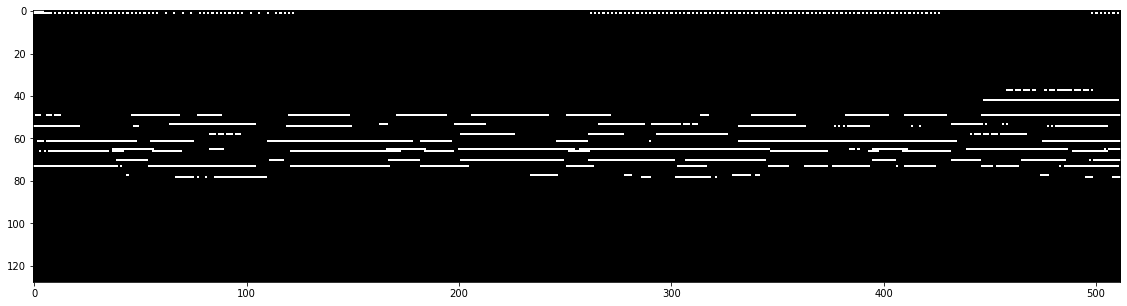

<Figure size 432x288 with 0 Axes>

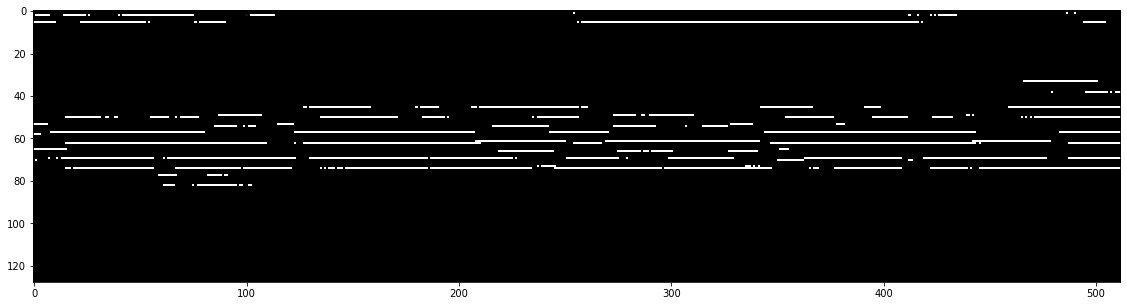

<Figure size 432x288 with 0 Axes>

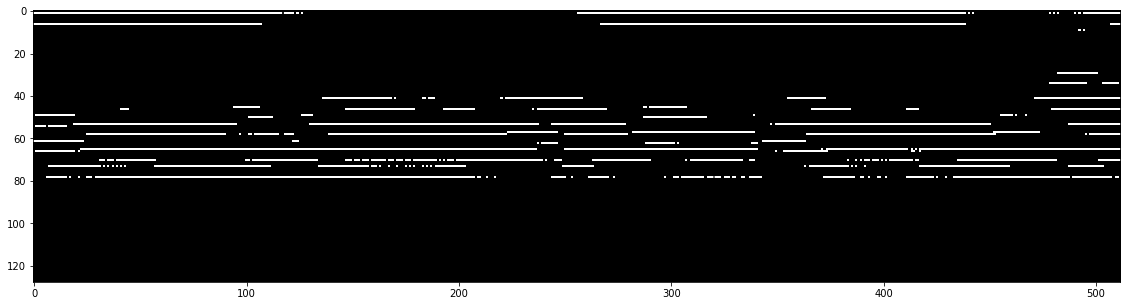

<Figure size 432x288 with 0 Axes>

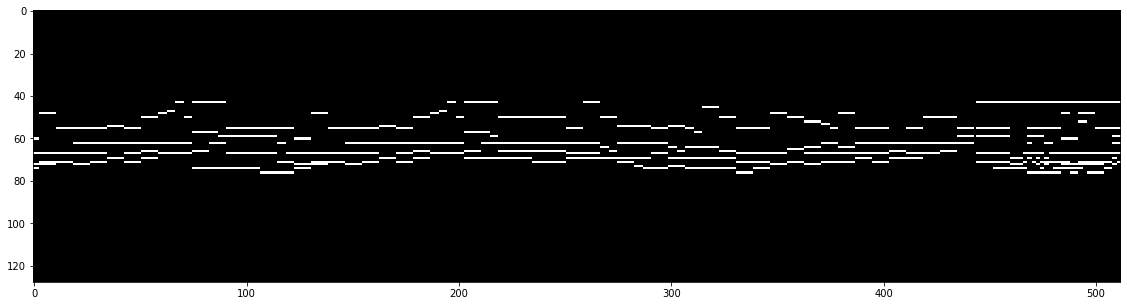

In [ ]:
import skimage
from skimage import util, io
from matplotlib import pyplot as plt
import io
plt.figure()
plt.figure(figsize = (20,5))
plt.imshow(generated[:,0:512],cmap='gray',interpolation='none')
plt.figure()
plt.figure(figsize = (20,5))
plt.imshow(generated[:,512:1024],cmap='gray',interpolation='none')
plt.figure()
plt.figure(figsize = (20,5))
plt.imshow(generated[:,1024:1536],cmap='gray',interpolation='none')
plt.figure()
plt.figure(figsize = (20,5))
plt.imshow(np.squeeze(prev_output) ,cmap='gray',interpolation='none')
plt.show()